# Introduction to End-To-End Automatic Speech Recognition
> **This notebook is a copy of the [original ASR example with Nemo by Nvidia](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/asr/ASR_with_NeMo.ipynb#scrollTo=oCFneEs1lRzp) with Weights and Biases integration added on top and some minor tweaks in code.**

This notebook contains a basic tutorial of Automatic Speech Recognition (ASR) concepts, introduced with code snippets using the [NeMo framework](https://github.com/NVIDIA/NeMo).


As part of this notebook, we will first introduce the basics of the main concepts behind speech recognition, then explore concrete examples of what the data looks like and walk through putting together a simple end-to-end ASR pipeline.

We assume that you are familiar with general machine learning concepts and can follow Python code, and we'll be using the [AN4 dataset from CMU](http://www.speech.cs.cmu.edu/databases/an4/) (with processing using `sox`).

## Conceptual Overview: What is ASR?

ASR, or **Automatic Speech Recognition**, refers to the problem of getting a program to automatically transcribe spoken language (speech-to-text). Our goal is usually to have a model that minimizes the **Word Error Rate (WER)** metric when transcribing speech input. In other words, given some audio file (e.g. a WAV file) containing speech, how do we transform this into the corresponding text with as few errors as possible?

Traditional speech recognition takes a generative approach, modeling the full pipeline of how speech sounds are produced in order to evaluate a speech sample. We would start from a **language model** that encapsulates the most likely orderings of words that are generated (e.g. an n-gram model), to a **pronunciation model** for each word in that ordering (e.g. a pronunciation table), to an **acoustic model** that translates those pronunciations to audio waveforms (e.g. a Gaussian Mixture Model).

Then, if we receive some spoken input, our goal would be to find the most likely sequence of text that would result in the given audio according to our generative pipeline of models. Overall, with traditional speech recognition, we try to model `Pr(audio|transcript)*Pr(transcript)`, and take the argmax of this over possible transcripts.

Over time, neural nets advanced to the point where each component of the traditional speech recognition model could be replaced by a neural model that had better performance and that had a greater potential for generalization. For example, we could replace an n-gram model with a neural language model, and replace a pronunciation table with a neural pronunciation model, and so on. However, each of these neural models need to be trained individually on different tasks, and errors in any model in the pipeline could throw off the whole prediction.

Thus, we can see the appeal of **end-to-end ASR architectures**: discriminative models that simply take an audio input and give a textual output, and in which all components of the architecture are trained together towards the same goal. The model's encoder would be akin to an acoustic model for extracting speech features, which can then be directly piped to a decoder which outputs text. If desired, we could integrate a language model that would improve our predictions, as well.

And the entire end-to-end ASR model can be trained at once--a much easier pipeline to handle! 

### End-To-End ASR

With an end-to-end model, we want to directly learn `Pr(transcript|audio)` in order to predict the transcripts from the original audio. Since we are dealing with sequential information--audio data over time that corresponds to a sequence of letters--RNNs are the obvious choice. But now we have a pressing problem to deal with: since our input sequence (number of audio timesteps) is not the same length as our desired output (transcript length), how do we match each time step from the audio data to the correct output characters?

Earlier speech recognition approaches relied on **temporally-aligned data**, in which each segment of time in an audio file was matched up to a corresponding speech sound such as a phoneme or word. However, if we would like to have the flexibility to predict letter-by-letter to prevent OOV (out of vocabulary) issues, then each time step in the data would have to be labeled with the letter sound that the speaker is making at that point in the audio file. With that information, it seems like we should simply be able to try to predict the correct letter for each time step and then collapse the repeated letters (e.g. the prediction output `LLLAAAAPPTOOOPPPP` would become `LAPTOP`). It turns out that this idea has some problems: not only does alignment make the dataset incredibly labor-intensive to label, but also, what do we do with words like "book" that contain consecutive repeated letters? Simply squashing repeated letters together would not work in that case!

![Alignment example](https://raw.githubusercontent.com/NVIDIA/NeMo/stable/tutorials/asr/images/alignment_example.png)

Modern end-to-end approaches get around this using methods that don't require manual alignment at all, so that the input-output pairs are really just the raw audio and the transcript--no extra data or labeling required. Let's briefly go over two popular approaches that allow us to do this, Connectionist Temporal Classification (CTC) and sequence-to-sequence models with attention.

#### Connectionist Temporal Classification (CTC)

In normal speech recognition prediction output, we would expect to have characters such as the letters from A through Z, numbers 0 through 9, spaces ("\_"), and so on. CTC introduces a new intermediate output token called the **blank token** ("-") that is useful for getting around the alignment issue.

With CTC, we still predict one token per time segment of speech, but we use the blank token to figure out where we can and can't collapse the predictions. The appearance of a blank token helps separate repeating letters that should not be collapsed. For instance, with an audio snippet segmented into `T=11` time steps, we could get predictions that look like `BOO-OOO--KK`, which would then collapse to `"BO-O-K"`, and then we would remove the blank tokens to get our final output, `BOOK`.

Now, we can predict one output token per time step, then collapse and clean to get sensible output without any fear of ambiguity from repeating letters! A simple way of getting predictions like this would be to apply a bidirectional RNN to the audio input, apply softmax over each time step's output, and then take the token with the highest probability. The method of always taking the best token at each time step is called **greedy decoding, or max decoding**.

To calculate our loss for backprop, we would like to know the log probability of the model producing the correct transcript, `log(Pr(transcript|audio))`. We can get the log probability of a single intermediate output sequence (e.g. `BOO-OOO--KK`) by summing over the log probabilities we get from each token's softmax value, but note that the resulting sum is different from the log probability of the transcript itself (`BOOK`). This is because there are multiple possible output sequences of the same length that can be collapsed to get the same transcript (e.g. `BBO--OO-KKK` also results in `BOOK`), and so we need to **marginalize over every valid sequence of length `T` that collapses to the transcript**.

Therefore, to get our transcript's log probability given our audio input, we must sum the log probabilities of every sequence of length `T` that collapses to the transcript (e.g. `log(Pr(output: "BOOK"|audio)) = log(Pr(BOO-OOO--KK|audio)) + log(Pr(BBO--OO-KKK|audio)) + ...`). In practice, we can use a dynamic programming approach to calculate this, accumulating our log probabilities over different "paths" through the softmax outputs at each time step.

If you would like a more in-depth explanation of how CTC works, or how we can improve our results by using a modified beam search algorithm, feel free to check out the Further Reading section at the end of this notebook for more resources.

#### Sequence-to-Sequence with Attention

One problem with CTC is that predictions at different time steps are conditionally independent, which is an issue because the words in a continuous utterance tend to be related to each other in some sensible way. With this conditional independence assumption, we can't learn a language model that can represent such dependencies, though we can add a language model on top of the CTC output to mitigate this to some degree.

A popular alternative is to use a sequence-to-sequence model with attention. A typical seq2seq model for ASR consists of some sort of **bidirectional RNN encoder** that consumes the audio sequence timestep-by-timestep, and where the outputs are then passed to an **attention-based decoder**. Each prediction from the decoder is based on attending to some parts of the entire encoded input, as well as the previously outputted tokens.

The outputs of the decoder can be anything from word pieces to phonemes to letters, and since predictions are not directly tied to time steps of the input, we can just continue producing tokens one-by-one until an end token is given (or we reach a specified max output length). This way, we do not need to deal with audio alignment, and our predicted transcript is just the sequence of outputs given by our decoder.

Now that we have an idea of what some popular end-to-end ASR models look like, let's take a look at the audio data we'll be working with for our example.

## Taking a Look at Our Data (AN4)

The AN4 dataset, also known as the Alphanumeric dataset, was collected and published by Carnegie Mellon University. It consists of recordings of people spelling out addresses, names, telephone numbers, etc., one letter or number at a time, as well as their corresponding transcripts. We choose to use AN4 for this tutorial because it is relatively small, with 948 training and 130 test utterances, and so it trains quickly.

Before we get started, let's download and prepare the dataset. The utterances are available as `.sph` files, so we will need to convert them to `.wav` for later processing. If you are not using Google Colab, please make sure you have [Sox](http://sox.sourceforge.net/) installed for this step--see the "Downloads" section of the linked Sox homepage. (If you are using Google Colab, Sox should have already been installed in the setup cell at the beginning.)

In [1]:
%matplotlib inline
import glob
import os
import json
import subprocess
import tarfile
import wandb
import librosa
import numpy as np
from pathlib import Path
import IPython.display as ipd
from tqdm.notebook import tqdm
import librosa.display
import matplotlib.pyplot as plt
from omegaconf import DictConfig

In [2]:
LOG_WANDB = True

In [3]:
# This is where the an4/ directory will be placed.
# Change this if you don't want the data to be extracted in the current directory.
data_dir = 'data'

You should have a folder called `an4` that contains `etc/an4_train.transcription`, `etc/an4_test.transcription`, audio files in `wav/an4_clstk` and `wav/an4test_clstk`, along with some other files we will not need.

Now we can load and take a look at the data. As an example, file `cen2-mgah-b.wav` is a 2.6 second-long audio recording of a man saying the letters "G L E N N" one-by-one. To confirm this, we can listen to the file:

In [4]:
# Load and listen to the audio file
example_file = data_dir + '/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav'
audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

In an ASR task, if this WAV file was our input, then "G L E N N" would be our desired output.

Let's plot the waveform, which is simply a line plot of the sequence of values that we read from the file. This is a format of viewing audio that you are likely to be familiar with seeing in many audio editors and visualizers:

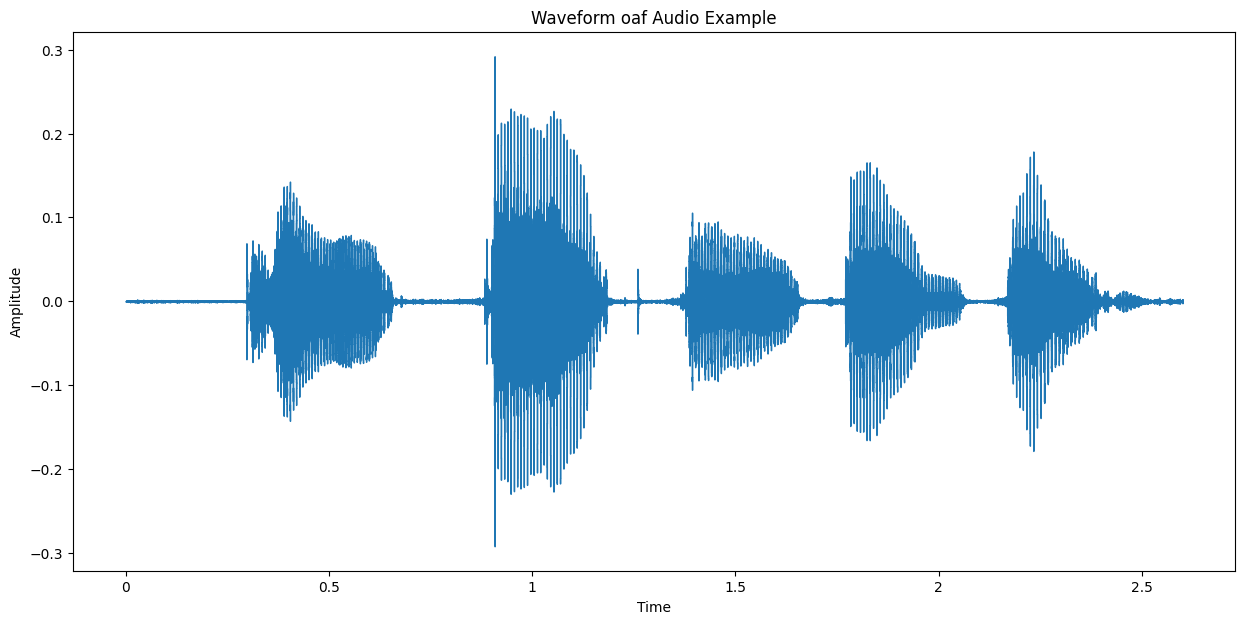

In [5]:
# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform oaf Audio Example')
plt.ylabel('Amplitude')
# see answer by Herman / Hammad Hassan:
# https://stackoverflow.com/questions/43533023/librosa-display-waveplotnp-arrayf-sr-22050-attributeerror-module-obje
_ = librosa.display.waveshow(audio)

We can see the activity in the waveform that corresponds to each letter in the audio, as our speaker here enunciates quite clearly!
You can kind of tell that each spoken letter has a different "shape," and it's interesting to note that last two blobs look relatively similar, which is expected because they are both the letter "N."

### Spectrograms and Mel Spectrograms

However, since audio information is more useful in the context of frequencies of sound over time, we can get a better representation than this raw sequence of 57,330 values.
We can apply a [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) on our audio signal to get something more useful: a **spectrogram**, which is a representation of the energy levels (i.e. amplitude, or "loudness") of each frequency (i.e. pitch) of the signal over the duration of the file.
A spectrogram (which can be viewed as a heat map) is a good way of seeing how the *strengths of various frequencies in the audio vary over time*, and is obtained by breaking up the signal into smaller, usually overlapping chunks and performing a Short-Time Fourier Transform (STFT) on each.

Let's examine what the spectrogram of our sample looks like.

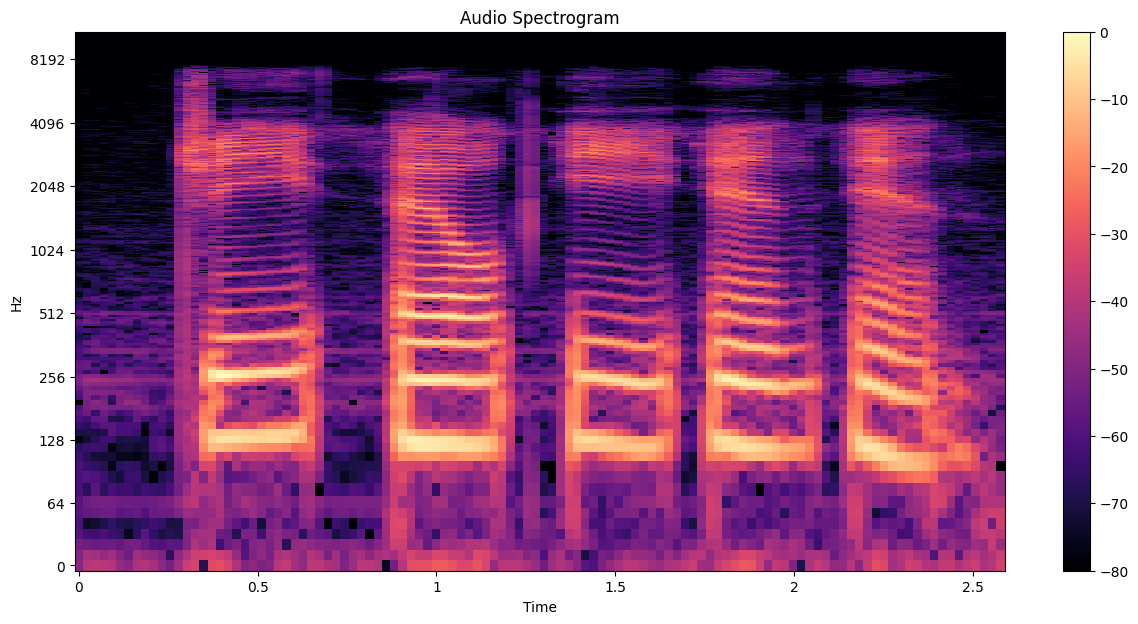

In [6]:
# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

Again, we are able to see each letter being pronounced, and that the last two blobs that correspond to the "N"s are pretty similar-looking. But how do we interpret these shapes and colors? Just as in the waveform plot before, we see time passing on the x-axis (all 2.6s of audio). But now, the y-axis represents different frequencies (on a log scale), and *the color on the plot shows the strength of a frequency at a particular point in time*.

We're still not done yet, as we can make one more potentially useful tweak: using the **Mel Spectrogram** instead of the normal spectrogram. This is simply a change in the frequency scale that we use from linear (or logarithmic) to the mel scale, which is "a perceptual scale of pitches judged by listeners to be equal in distance from one another" (from [Wikipedia](https://en.wikipedia.org/wiki/Mel_scale)).

In other words, it's a transformation of the frequencies to be more aligned to what humans perceive; a change of +1000Hz from 2000Hz->3000Hz sounds like a larger difference to us than 9000Hz->10000Hz does, so the mel scale normalizes this such that equal distances sound like equal differences to the human ear. Intuitively, we use the mel spectrogram because in this case we are processing and transcribing human speech, such that transforming the scale to better match what we hear is a useful procedure.

/tmp/ipykernel_10915/3205782580.py:2: FutureWarning: Pass y=[-2.5449268e-04 -2.1176333e-04  7.7573779e-05 ...  1.8370128e-03
  1.9144358e-03  1.2261863e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate)


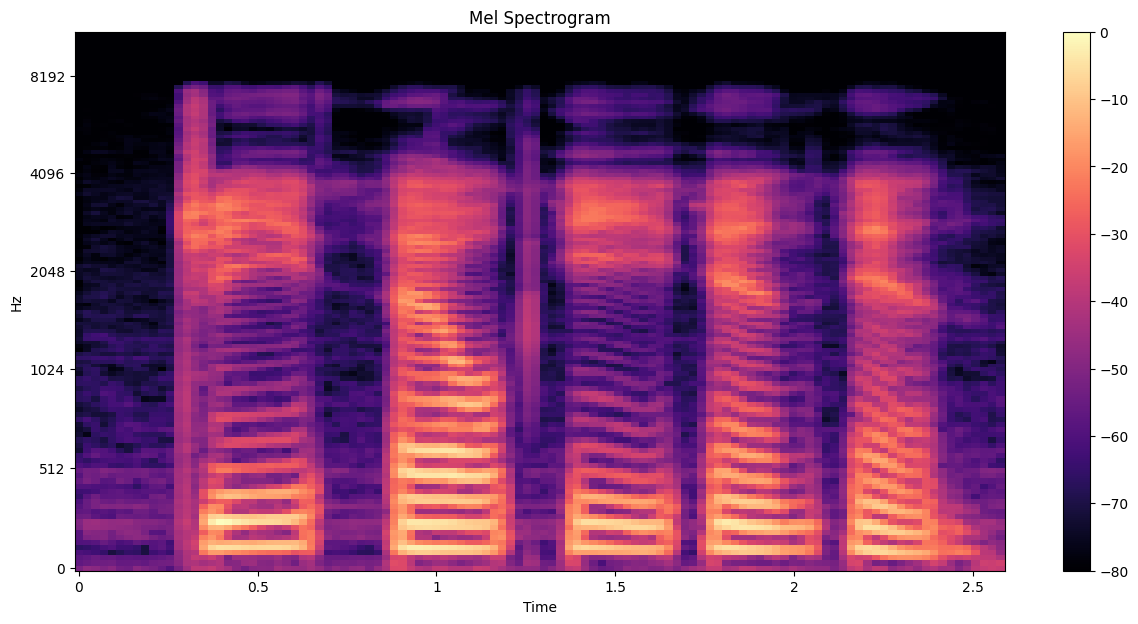

In [7]:
# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

## Creating Data Manifests from Scratch

If we were to train a model from scratch, we would have to setup our data in the right format. Therefore we need to create manifests for our training and evaluation data, which will contain the metadata of our audio files. *NeMo data sets take in a standardized manifest format where each line corresponds to one sample of audio, such that the number of lines in a manifest is equal to the number of samples that are represented by that manifest. A line must contain the path to an audio file, the corresponding transcript (or path to a transcript file), and the duration of the audio sample.*

Here's an example of what one line in a NeMo-compatible manifest might look like:
```
{"audio_filepath": "path/to/audio.wav", "duration": 3.45, "text": "this is a nemo tutorial"}
```

We can build our training and evaluation manifests using `an4/etc/an4_train.transcription` and `an4/etc/an4_test.transcription`, which have lines containing transcripts and their corresponding audio file IDs:
```
...
<s> P I T T S B U R G H </s> (cen5-fash-b)
<s> TWO SIX EIGHT FOUR FOUR ONE EIGHT </s> (cen7-fash-b)
...
```

In [8]:
# Function to build a manifest
def build_manifest(transcripts_path, manifest_path, wav_path):
    audio_paths=[]; durations=[]; texts=[]
    with open(transcripts_path, 'r') as fin:
        with open(manifest_path, 'w') as fout:
            for line in fin:
                # Lines look like this:
                # <s> transcript </s> (fileID)
                transcript = line[: line.find('(')-1].lower()
                transcript = transcript.replace('<s>', '').replace('</s>', '')
                transcript = transcript.strip()

                file_id = line[line.find('(')+1 : -2]  # e.g. "cen4-fash-b"
                audio_path = os.path.join(
                    data_dir, wav_path,
                    file_id[file_id.find('-')+1 : file_id.rfind('-')],
                    file_id + '.wav')

                duration = librosa.core.get_duration(filename=audio_path)

                audio_paths.append(audio_path)
                durations.append(duration)
                texts.append(transcript)
                # Write the metadata to the manifest
                metadata = {
                    "audio_filepath": audio_path,
                    "duration": duration,
                    "text": transcript
                }
                json.dump(metadata, fout)
                fout.write('\n') 
    return audio_paths, durations, texts

In [9]:
# Building Manifests
train_transcripts = data_dir + '/an4/etc/an4_train.transcription'
train_manifest = data_dir + '/an4/train_manifest.json'
train_audio_paths, train_durations, train_texts = build_manifest(train_transcripts, train_manifest, 'an4/wav/an4_clstk')

In [10]:
test_transcripts = data_dir + '/an4/etc/an4_test.transcription'
test_manifest = data_dir + '/an4/test_manifest.json'
test_audio_paths, test_durations, test_texts = build_manifest(test_transcripts, test_manifest, 'an4/wav/an4test_clstk')

Now, once we have the train and test manifests ready, let's see how they look like!

The first five rows of the `train_manifest` look like this: (You can easily see for yourself with this command - `!head {train_manifest} -n5`)
```python
{"audio_filepath": "./an4/wav/an4_clstk/fash/an251-fash-b.wav", "duration": 1.0, "text": "yes"}
{"audio_filepath": "./an4/wav/an4_clstk/fash/an253-fash-b.wav", "duration": 0.7, "text": "go"}
{"audio_filepath": "./an4/wav/an4_clstk/fash/an254-fash-b.wav", "duration": 0.9, "text": "yes"}
{"audio_filepath": "./an4/wav/an4_clstk/fash/an255-fash-b.wav", "duration": 2.6, "text": "u m n y h six"}
{"audio_filepath": "./an4/wav/an4_clstk/fash/cen1-fash-b.wav", "duration": 3.5, "text": "h i n i c h"}
```

Now, we haven't still been able to explore of play around with our dataset. Let's use Weights and Biases Tables to do just that! 

First, we go through every `audio_filepath` and save a spectogram and mel-spectogram image for the audio file. Next, we create a `wandb.Table` to log the *file name, audio file, text (the target for our model), spectogram image & mel spectogram image*.

You can find the logged table here - https://wandb.ai/wandb_fc/Automatic%20Speech%20Recognition%20(ASR)/runs/1m8pgo43?workspace=user-aarora.

In [11]:
def save_spectogram_as_img(audio_path, datadir, plt_type='spec'):
    filename = os.path.basename(audio_path)
    out_path = os.path.join(datadir, filename.replace('.wav', '.png'))
    audio, sample_rate = librosa.load(audio_path)
    if plt_type=='spec':
        spec = np.abs(librosa.stft(audio))
        spec_db = librosa.amplitude_to_db(spec, ref=np.max)
    else:
        mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    fig = plt.Figure()
    ax = fig.add_subplot()
    ax.set_axis_off()
    
    librosa.display.specshow(
        spec_db if plt_type=='spec' else mel_spec_db, 
        y_axis='log' if plt_type=='spec' else 'mel', 
        x_axis='time', ax=ax)

    fig.savefig(out_path)

In [12]:
# convert audio file to spectogram and mel spectogram images
if not os.path.exists('./data/an4/melspectogram_images/'):
    for path in tqdm(train_audio_paths): 
        save_spectogram_as_img(path, datadir='./data/an4/images/')
        save_spectogram_as_img(path, datadir='./data/an4/melspectogram_images/', plt_type='mel')

In [13]:
# log filename, playable audio, duration of audio, transcript, spectogram and mel spectogram to W&B for ease of reference
if LOG_WANDB:
    # create W&B Table
    wandb.init(project="ASR")

    audio_table = wandb.Table(
        columns=['Filename', 'Audio File', 'Duration', 'Transcript', 'Spectogram', 'Mel-Spectogram'])

    for path, duration, text in zip(train_audio_paths, train_durations, train_texts):
        filename = os.path.basename(path)
        img_fn   = filename.replace('.wav', '.png')
        spec_pth = os.path.join('./data/an4/images', img_fn)
        melspec_pth = os.path.join('./data/an4/melspectogram_images', img_fn)
        audio_table.add_data(
            filename, wandb.Audio(path), duration, text, wandb.Image(spec_pth), wandb.Image(melspec_pth))

    wandb.log({"Train Data": audio_table})
    wandb.finish();
else:
    print("WandB: Not logged in!")

wandb: Currently logged in as: mdroth. Use `wandb login --relogin` to force relogin


Running the above code gives us a Weights and Biases table that looks like below:

![Audio Table](https://raw.githubusercontent.com/amaarora/images/main/audio-table.png)

As can be seen, it is much easier to explore the dataset using W&B Tables where everything is one place. You can play the Audio and also check the transcribe. 

Great! Now that we've been able to create our own dataset and have a super simple way to explore the data, let's move on to the model.

## Convolutional ASR Models

Let's take a look at the model that we will be building, and how we specify its parameters.

### The Jasper Model

We will be training a small [Jasper (Just Another SPeech Recognizer) model](https://arxiv.org/abs/1904.03288) from scratch (e.g. initialized randomly). 
In brief, Jasper architectures consist of a repeated block structure that utilizes 1D convolutions.
In a Jasper_KxR model, `R` sub-blocks (consisting of a 1D convolution, batch norm, ReLU, and dropout) are grouped into a single block, which is then repeated `K` times.
We also have a one extra block at the beginning and a few more at the end that are invariant of `K` and `R`, and we use CTC loss.

### The QuartzNet Model

The QuartzNet is better variant of Jasper with a key difference that it uses time-channel separable 1D convolutions. This allows it to dramatically reduce number of weights while keeping similar accuracy.

A Jasper/QuartzNet models look like this (QuartzNet model is pictured):

![QuartzNet with CTC](https://developer.nvidia.com/blog/wp-content/uploads/2020/05/quartznet-model-architecture-1-625x742.png)

# Using NeMo for Automatic Speech Recognition

Now that we have an idea of what ASR is and how the audio data looks like, we can start using NeMo to do some ASR!

We'll be using the **Neural Modules (NeMo) toolkit** for this part, so if you haven't already, you should download and install NeMo and its dependencies. To do so, just follow the directions on the [GitHub page](https://github.com/NVIDIA/NeMo), or in the [documentation](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/).

NeMo lets us easily hook together the components (modules) of our model, such as the data layer, intermediate layers, and various losses, without worrying too much about implementation details of individual parts or connections between modules. NeMo also comes with complete models which only require your data and hyperparameters for training.

In [14]:
# NeMo's "core" package
import nemo
# NeMo's ASR collection - this collections contains complete ASR models and
# building blocks (modules) for ASR
import nemo.collections.asr as nemo_asr

[NeMo W 2022-09-20 03:24:06 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.


## Using an Out-of-the-Box Model

NeMo's ASR collection comes with many building blocks and even complete models that we can use for training and evaluation. Moreover, several models come with pre-trained weights. Let's instantiate a complete QuartzNet15x5 model.

In [15]:
# This line will download pre-trained QuartzNet15x5 model from NVIDIA's NGC cloud and instantiate it for you
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2022-09-20 03:24:14 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo to /home/matthias/.cache/torch/NeMo/NeMo_1.11.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
100% [....................................................] 71087043 / 71087043[NeMo I 2022-09-20 03:25:19 common:910] Instantiating model from pre-trained checkpoint
[NeMo I 2022-09-20 03:25:20 features:223] PADDING: 16
[NeMo I 2022-09-20 03:25:23 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /home/matthias/.cache/torch/NeMo/NeMo_1.11.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Next, we'll simply add paths to files we want to transcribe into the list and pass it to our model. Note that it will work for relatively short (<25 seconds) files. 

In [16]:
files = ['./data/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav']
for fname, transcription in zip(files, quartznet.transcribe(paths2audio_files=files)):
  print(f"Audio in {fname} was recognized as: {transcription}")

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Audio in ./data/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav was recognized as: g l e n n


That was easy! But there are plenty of scenarios where you would want to fine-tune the model on your own data or even train from scratch. For example, this out-of-the box model will obviously not work for Spanish and would likely perform poorly for telephone audio. So if you have collected your own data, you certainly should attempt to fine-tune or train on it!

## Training from Scratch

To train from scratch, you need to prepare your training data in the right format and specify your models architecture.

### Specifying Our Model with a YAML Config File

For this tutorial, we'll build a *Jasper_4x1 model*, with `K=4` blocks of single (`R=1`) sub-blocks and a *greedy CTC decoder*, using the configuration found in `./configs/config.yaml`.

If we open up this config file, we find model section which describes architecture of our model. A model contains an entry labeled `encoder`, with a field called `jasper` that contains a list with multiple entries. Each of the members in this list specifies one block in our model, and looks something like this:
```
- filters: 128
  repeat: 1
  kernel: [11]
  stride: [2]
  dilation: [1]
  dropout: 0.2
  residual: false
  separable: true
  se: true
  se_context_size: -1
```
The first member of the list corresponds to the first block in the Jasper architecture diagram, which appears regardless of `K` and `R`.
Next, we have four entries that correspond to the `K=4` blocks, and each has `repeat: 1` since we are using `R=1`.
These are followed by two more entries for the blocks that appear at the end of our Jasper model before the CTC loss.

There are also some entries at the top of the file that specify how we will handle training (`train_ds`) and validation (`validation_ds`) data.

Using a YAML config such as this is helpful for getting a quick and human-readable overview of what your architecture looks like, and allows you to swap out model and run configurations easily without needing to change your code.

In [20]:
# --- Config Information ---#
try:
    from ruamel.yaml import YAML
except ModuleNotFoundError:
    from ruamel_yaml import YAML
config_path = './config.yaml'

yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)
print(params)

{'name': 'QuartzNet15x5', 'sample_rate': 16000, 'repeat': 1, 'dropout': 0.0, 'separable': True, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'model': {'train_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'trim_silence': True, 'max_duration': 16.7, 'shuffle': True, 'num_workers': 8, 'pin_memory': True, 'is_tarred': False, 'tarred_audio_filepaths': None, 'shuffle_n': 2048, 'bucketing_strategy': 'synced_randomized', 'bucketing_batch_size': None}, 'validation_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'shuffle': False, 'num_work

**It** is really difficult to look at the params above. Especially difficult to share params and results with a fellow teammate. Below, we will see how easy it is to use W&B integration with PyTorch lightning and how Weights and Biases stores results, configs, tables all in one place which is really convenient when trying to replicate results! 

### Training with PyTorch Lightning

NeMo models and modules can be used in any PyTorch code where torch.nn.Module is expected.

However, NeMo's models are based on [PytorchLightning's](https://github.com/PyTorchLightning/pytorch-lightning) LightningModule and we recommend you use PytorchLightning for training and fine-tuning as it makes using mixed precision and distributed training very easy. So to start, let's create Trainer instance for training on GPU for 50 epochs

Did you know that **Weights and Biases** has already been integrated into popular frameworks such as PyTorch Lightning? We could at this stage just use a `WandbLogger` to log all our progress during training to Weights and Biases! 

This is great because it allows us to replicate experiments very easily. 

In [21]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger  

In [22]:
# initialize W&B logger and specify project name to store results to
wandb_logger = WandbLogger(project="ASR", log_model='all')

# set config params for W&B experiment
for k,v in params.items(): 
    wandb_logger.experiment.config[k]=v 

# initialize trainer with W&B logger    
trainer = pl.Trainer(gpus=1, max_epochs=10, logger=wandb_logger)

[NeMo W 2022-09-20 03:37:27 nemo_logging:349] /home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
      rank_zero_warn(
    
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Next, we instantiate and ASR model based on our ``config.yaml`` file from the previous section.
Note that this is a stage during which we also tell the model where our training and validation manifests are.

In [23]:
# Update train and test data path
params['model']['train_ds']['manifest_filepath'] = train_manifest
params['model']['validation_ds']['manifest_filepath'] = test_manifest

In [24]:
# initialize model
first_asr_model = nemo_asr.models.EncDecCTCModel(cfg=DictConfig(params['model']), trainer=trainer)

[NeMo I 2022-09-20 03:37:32 audio_to_text_dataset:41] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-09-20 03:37:32 audio_to_text_dataset:41] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-09-20 03:37:32 collections:194] Dataset loaded with 948 files totalling 0.71 hours
[NeMo I 2022-09-20 03:37:32 collections:195] 0 files were filtered totalling 0.00 hours


[NeMo W 2022-09-20 03:37:32 nemo_logging:349] /home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      warnings.warn(_create_warning_msg(
    


[NeMo I 2022-09-20 03:37:32 audio_to_text_dataset:41] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-09-20 03:37:32 audio_to_text_dataset:41] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-09-20 03:37:32 collections:194] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2022-09-20 03:37:32 collections:195] 0 files were filtered totalling 0.00 hours
[NeMo I 2022-09-20 03:37:32 features:223] PADDING: 16


With that, we can start training with just one line!

In [25]:
# Start training - this will automatically store results to Weights and Biases
trainer.fit(first_asr_model)
wandb.finish();

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2022-09-20 03:37:38 modelPT:597] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2022-09-20 03:37:38 lr_scheduler:910] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f84b0923340>" 
    will be used during training (effective maximum steps = 300) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 300
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 1.2 M 
2 | decoder           | ConvASRDecoder                    | 29.7 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.836     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

TypeError: 'float' object cannot be interpreted as an integer

There we go! We've put together a full training pipeline for the model and trained it for 10 epochs.

### Hyperparameter tuning using W&B Sweeps

Additionally we might also want to tune some hyperparameters. Below, I've just taken a small subset of all the possible parameters in `params`, such as `lr`, `epoch` and `dropout` to showcase hyperparameter tuning using **[W&B Sweeps](https://docs.wandb.ai/guides/sweeps).**

There are many benefits of using W&B sweeps, from the docs:

1. **Quick setup:** Get going with just a few lines of code. You can launch a sweep across dozens of machines, and it's just as easy as starting a sweep on your laptop.
2. **Transparent:** We cite all the algorithms we're using, and our code is open source.
3. **Powerful:** Our sweeps are completely customizable and configurable. 

It's really simple to add sweeps to this ASR example. First, we define a sweep config as below:

In [26]:
sweep_config = {
  "method": "random",   # Random search
  "metric": {           # We want to minimize `val_loss`
      "name": "val_loss",
      "goal": "minimize"
  },
  "parameters": {
        "lr": {
            # log uniform distribution between exp(min) and exp(max)
            "distribution": "log_uniform",
            "min": -9.21,   # exp(-9.21) = 1e-4
            "max": -4.61    # exp(-4.61) = 1e-2
        },
        "epoch": {
            "distribution": "int_uniform",
            "min": 3,
            "max": 10
        },
        "dropout": {
            "distribution": "uniform",
            "min": 0,  
            "max": 0.25     
        }
      
    }
}

Next, we define a `sweep_iteration` function as below. The key difference is that now the values of these are taken from `wandb.config` instead of being set to hard values.

Example, 
```python
    params['model']['optim']['lr'] = wandb.config.lr
    params['model']['encoder']['jasper'][-1]['dropout'] = wandb.config.dropout
```

Because these values change with every sweep, we take these values from `wandb.config` as below.

In [27]:
def sweep_iteration():
    # load config
    config_path = './configs/config.yaml'
    yaml = YAML(typ='safe')
    with open(config_path) as f:
        params = yaml.load(f)    
        
    # set up W&B logger
    wandb.init()    # required to have access to `wandb.config`
    wandb_logger = WandbLogger(log_model='all')  # log final model

    # setup data
    params['model']['train_ds']['manifest_filepath'] = train_manifest
    params['model']['validation_ds']['manifest_filepath'] = test_manifest
    
    # setup sweep param
    params['model']['optim']['lr'] = wandb.config.lr
    params['model']['encoder']['jasper'][-1]['dropout'] = wandb.config.dropout
    
    trainer = pl.Trainer(gpus=1, max_epochs=wandb.config.epoch, logger=wandb_logger)
    
    # setup model - note how we refer to sweep parameters with wandb.config
    model = nemo_asr.models.EncDecCTCModel(cfg=DictConfig(params['model']), trainer=trainer)

    # train
    trainer.fit(model)

Finally, we create a wandb sweep and pass in the `wandb_config` to it. Next, we simply create an agent that runs various runs and based on the sweep "method", selects parameters to compare `val_loss` for various parameter values.

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="ASR")
wandb.agent(sweep_id, function=sweep_iteration)

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. lr uses log_uniform, where min/max specify base-e exponents. Use log_uniform_values to specify limit values.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 09un31qf
Sweep URL: https://wandb.ai/mdroth/ASR/sweeps/09un31qf


wandb: Waiting for W&B process to finish... (success).
wandb:                                                                                
wandb: Synced snowy-flower-6: https://wandb.ai/mdroth/ASR/runs/387rvm21
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20220920_032733-387rvm21/logs
wandb: Agent Starting Run: s4gs5sm8 with config:
wandb: 	dropout: 0.033946674843566754
wandb: 	epoch: 9
wandb: 	lr: 0.00016874652554677914
Exception in thread Thread-17 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/a

wandb: Agent Starting Run: ubt3hoff with config:
wandb: 	dropout: 0.0972319154205554
wandb: 	epoch: 7
wandb: 	lr: 0.005214078383292085
Exception in thread Thread-20 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.finis

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1zd61h1n with config:
wandb: 	dropout: 0.12314760772943584
wandb: 	epoch: 9
wandb: 	lr: 0.0005134188824935064
Exception in thread Thread-23 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 1jy27s8u with config:
wandb: 	dropout: 0.06093516462000617
wandb: 	epoch: 6
wandb: 	lr: 0.0001287519009251699
Exception in thread Thread-26 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mlz2cj0b with config:
wandb: 	dropout: 0.14706050893792674
wandb: 	epoch: 9
wandb: 	lr: 0.0010074048440506672
Exception in thread Thread-29 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: dzpqydfn with config:
wandb: 	dropout: 0.11857768740101352
wandb: 	epoch: 5
wandb: 	lr: 0.0008945957770201382
Exception in thread Thread-32 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7snejfxz with config:
wandb: 	dropout: 0.05476488208998806
wandb: 	epoch: 9
wandb: 	lr: 0.001638113985779167
Exception in thread Thread-35 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: mffm50ot with config:
wandb: 	dropout: 0.10338864641993686
wandb: 	epoch: 5
wandb: 	lr: 0.002070246436676273
Exception in thread Thread-38 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i91wgbe1 with config:
wandb: 	dropout: 0.0341949304198583
wandb: 	epoch: 4
wandb: 	lr: 0.00023077287150417305
Exception in thread Thread-41 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 127t48gs with config:
wandb: 	dropout: 0.183989578967454
wandb: 	epoch: 8
wandb: 	lr: 0.00030573796503946467
Exception in thread Thread-44 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j75efp3a with config:
wandb: 	dropout: 0.006112510105817037
wandb: 	epoch: 5
wandb: 	lr: 0.0013964862830803649
Exception in thread Thread-47 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 73x74acg with config:
wandb: 	dropout: 0.1271369866648428
wandb: 	epoch: 10
wandb: 	lr: 0.0009597067464671652
Exception in thread Thread-50 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uz0furbf with config:
wandb: 	dropout: 0.12082061292332091
wandb: 	epoch: 7
wandb: 	lr: 0.0001588844842886668
Exception in thread Thread-53 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 7igedame with config:
wandb: 	dropout: 0.17869173682880943
wandb: 	epoch: 5
wandb: 	lr: 0.0002654807627233684
Exception in thread Thread-56 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 816q5gwq with config:
wandb: 	dropout: 0.08737122874885231
wandb: 	epoch: 6
wandb: 	lr: 0.009659141738664188
Exception in thread Thread-59 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: ukztn1sq with config:
wandb: 	dropout: 0.17069847044484837
wandb: 	epoch: 10
wandb: 	lr: 0.00138714974251398
Exception in thread Thread-62 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8eutohwj with config:
wandb: 	dropout: 0.08230910121759938
wandb: 	epoch: 10
wandb: 	lr: 0.0004733965128390672
Exception in thread Thread-65 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: ylj1fnm4 with config:
wandb: 	dropout: 0.14678731463559297
wandb: 	epoch: 7
wandb: 	lr: 0.00023002144727227872
Exception in thread Thread-68 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e8e8xmc4 with config:
wandb: 	dropout: 0.06941715211380253
wandb: 	epoch: 10
wandb: 	lr: 0.009434529480796648
Exception in thread Thread-71 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: dtd1wm6w with config:
wandb: 	dropout: 0.1179417296997426
wandb: 	epoch: 5
wandb: 	lr: 0.0006838408832438848
Exception in thread Thread-74 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9b2bhgk2 with config:
wandb: 	dropout: 0.14233929948310128
wandb: 	epoch: 5
wandb: 	lr: 0.00012633468581445031
Exception in thread Thread-77 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: hr6soxgm with config:
wandb: 	dropout: 0.2359445457035082
wandb: 	epoch: 9
wandb: 	lr: 0.004303816457977739
Exception in thread Thread-80 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.finis

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: egypotqj with config:
wandb: 	dropout: 0.13788022515625162
wandb: 	epoch: 7
wandb: 	lr: 0.0010074758986899064
Exception in thread Thread-83 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: k4qgri24 with config:
wandb: 	dropout: 0.18622366739344903
wandb: 	epoch: 6
wandb: 	lr: 0.00031252757694262404
Exception in thread Thread-86 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n59i6s0r with config:
wandb: 	dropout: 0.045301969924163105
wandb: 	epoch: 9
wandb: 	lr: 0.004756652911253195
Exception in thread Thread-89 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: dxmhfqxf with config:
wandb: 	dropout: 0.0854993711817453
wandb: 	epoch: 7
wandb: 	lr: 0.00018106042416734128
Exception in thread Thread-92 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yfjtdnmr with config:
wandb: 	dropout: 0.01643543585462498
wandb: 	epoch: 7
wandb: 	lr: 0.0016579087227953555
Exception in thread Thread-95 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: r7zpkq7y with config:
wandb: 	dropout: 0.18865961810104803
wandb: 	epoch: 7
wandb: 	lr: 0.00023101803177413664
Exception in thread Thread-98 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8ncqjff1 with config:
wandb: 	dropout: 0.14721641118209094
wandb: 	epoch: 6
wandb: 	lr: 0.0006685462019722527
Exception in thread Thread-101 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 0abf8cqh with config:
wandb: 	dropout: 0.03908042151935598
wandb: 	epoch: 3
wandb: 	lr: 0.007621093291013266
Exception in thread Thread-104 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 590pn4pu with config:
wandb: 	dropout: 0.08934563593340053
wandb: 	epoch: 4
wandb: 	lr: 0.001781875497875446
Exception in thread Thread-107 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: s5pdcv9h with config:
wandb: 	dropout: 0.04600284650713196
wandb: 	epoch: 10
wandb: 	lr: 0.0007488460820964671
Exception in thread Thread-110 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f4qtt9o8 with config:
wandb: 	dropout: 0.15895360348695375
wandb: 	epoch: 10
wandb: 	lr: 0.005011518417322287
Exception in thread Thread-113 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: dzjujo99 with config:
wandb: 	dropout: 0.002266747299567967
wandb: 	epoch: 6
wandb: 	lr: 0.0006369051354417122
Exception in thread Thread-116 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8585rpet with config:
wandb: 	dropout: 0.016421103025601375
wandb: 	epoch: 3
wandb: 	lr: 0.004527097182096227
Exception in thread Thread-119 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: oc6amwcm with config:
wandb: 	dropout: 0.044542573134575325
wandb: 	epoch: 9
wandb: 	lr: 0.007407283323639415
Exception in thread Thread-122 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 70wezrsg with config:
wandb: 	dropout: 0.1549970652247342
wandb: 	epoch: 8
wandb: 	lr: 0.005851239908041608
Exception in thread Thread-125 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: 3p77cp1e with config:
wandb: 	dropout: 0.08376772091549586
wandb: 	epoch: 7
wandb: 	lr: 0.00132396906999962
Exception in thread Thread-128 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: boyfeldz with config:
wandb: 	dropout: 0.027557085993974023
wandb: 	epoch: 4
wandb: 	lr: 0.00013325883249901236
Exception in thread Thread-131 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/

wandb: Agent Starting Run: akz8wa6a with config:
wandb: 	dropout: 0.2447016277258518
wandb: 	epoch: 6
wandb: 	lr: 0.00028170461244064656
Exception in thread Thread-134 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2yc0u6yj with config:
wandb: 	dropout: 0.11988325825064236
wandb: 	epoch: 3
wandb: 	lr: 0.009232884690586914
Exception in thread Thread-137 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: xlwdhsfs with config:
wandb: 	dropout: 0.10455035061341868
wandb: 	epoch: 8
wandb: 	lr: 0.002024451528234937
Exception in thread Thread-140 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mpknts8t with config:
wandb: 	dropout: 0.08145898212576055
wandb: 	epoch: 5
wandb: 	lr: 0.00021131908382336504
Exception in thread Thread-143 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: 728gwmpi with config:
wandb: 	dropout: 0.08699726293637591
wandb: 	epoch: 10
wandb: 	lr: 0.0030736867427444713
Exception in thread Thread-146 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sttoi2se with config:
wandb: 	dropout: 0.06737770374547289
wandb: 	epoch: 8
wandb: 	lr: 0.0005185065452510512
Exception in thread Thread-149 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qrc58zwn with config:
wandb: 	dropout: 0.19201935096631972
wandb: 	epoch: 9
wandb: 	lr: 0.0005404292004453685
Exception in thread Thread-152 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: lgccbqlx with config:
wandb: 	dropout: 0.15290477919424214
wandb: 	epoch: 3
wandb: 	lr: 0.0003091587754730875
Exception in thread Thread-155 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xabfbyqy with config:
wandb: 	dropout: 0.14985687581177615
wandb: 	epoch: 3
wandb: 	lr: 0.0030822202568543235
Exception in thread Thread-158 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: g820axkt with config:
wandb: 	dropout: 0.12434122528677422
wandb: 	epoch: 6
wandb: 	lr: 0.009272029606120473
Exception in thread Thread-161 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 92awmanp with config:
wandb: 	dropout: 0.1087024697432628
wandb: 	epoch: 5
wandb: 	lr: 0.0005095900496783385
Exception in thread Thread-164 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: nlmynnne with config:
wandb: 	dropout: 0.21693098363125823
wandb: 	epoch: 3
wandb: 	lr: 0.0013200843969435774
Exception in thread Thread-167 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u8oxvba0 with config:
wandb: 	dropout: 0.1566275645760727
wandb: 	epoch: 8
wandb: 	lr: 0.00013290190856411754
Exception in thread Thread-170 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: b5z5kkbc with config:
wandb: 	dropout: 0.11245763532141262
wandb: 	epoch: 6
wandb: 	lr: 0.0053221342648120335
Exception in thread Thread-173 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q2wciub8 with config:
wandb: 	dropout: 0.20209043415914643
wandb: 	epoch: 10
wandb: 	lr: 0.0031019368911837913
Exception in thread Thread-176 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: du9q6ge8 with config:
wandb: 	dropout: 0.20335937605079016
wandb: 	epoch: 7
wandb: 	lr: 0.00012099938711416596
Exception in thread Thread-179 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c1ga0bkx with config:
wandb: 	dropout: 0.17617931383017774
wandb: 	epoch: 10
wandb: 	lr: 0.004339389101391413
Exception in thread Thread-182 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 7ucmqmck with config:
wandb: 	dropout: 0.17903652230260658
wandb: 	epoch: 8
wandb: 	lr: 0.0060630193560112
Exception in thread Thread-185 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.finis

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qrkemuhw with config:
wandb: 	dropout: 0.24164598302168888
wandb: 	epoch: 6
wandb: 	lr: 0.0017232563996028671
Exception in thread Thread-188 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: jklvp5tf with config:
wandb: 	dropout: 0.05606601453472418
wandb: 	epoch: 6
wandb: 	lr: 0.00011707259794501068
Exception in thread Thread-191 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mzlcy76p with config:
wandb: 	dropout: 0.09076805051511184
wandb: 	epoch: 9
wandb: 	lr: 0.0003873220204945184
Exception in thread Thread-194 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: l4uvcwh6 with config:
wandb: 	dropout: 0.10384714818787766
wandb: 	epoch: 7
wandb: 	lr: 0.001663140472724257
Exception in thread Thread-197 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oy9ijpxr with config:
wandb: 	dropout: 0.17563928780354454
wandb: 	epoch: 3
wandb: 	lr: 0.0004786716092567458
Exception in thread Thread-200 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: warkxc8i with config:
wandb: 	dropout: 0.22269216846096743
wandb: 	epoch: 7
wandb: 	lr: 0.004212356101530388
Exception in thread Thread-203 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nliz8bvr with config:
wandb: 	dropout: 0.029454304920425556
wandb: 	epoch: 8
wandb: 	lr: 0.007966825299812139
Exception in thread Thread-206 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: f5u4hube with config:
wandb: 	dropout: 0.11266984427038536
wandb: 	epoch: 5
wandb: 	lr: 0.007167530582254037
Exception in thread Thread-209 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ch3i7n2p with config:
wandb: 	dropout: 0.02014971565749943
wandb: 	epoch: 9
wandb: 	lr: 0.0011587264831201313
Exception in thread Thread-212 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: hnkqrfu8 with config:
wandb: 	dropout: 0.11244689823626848
wandb: 	epoch: 9
wandb: 	lr: 0.0002899377058604745
Exception in thread Thread-215 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cehhters with config:
wandb: 	dropout: 0.14060218106316985
wandb: 	epoch: 5
wandb: 	lr: 0.00042451128221448575
Exception in thread Thread-218 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: dyjvoxf2 with config:
wandb: 	dropout: 0.14284665570622643
wandb: 	epoch: 9
wandb: 	lr: 0.0036451027881699394
Exception in thread Thread-221 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q8lmxjbp with config:
wandb: 	dropout: 0.23378625258875796
wandb: 	epoch: 3
wandb: 	lr: 0.0017786545730230586
Exception in thread Thread-224 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: f1ao8cum with config:
wandb: 	dropout: 0.21078372078285307
wandb: 	epoch: 9
wandb: 	lr: 0.001900547848792482
Exception in thread Thread-227 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h9zt1xxs with config:
wandb: 	dropout: 0.1750083490152392
wandb: 	epoch: 3
wandb: 	lr: 0.008861196202892134
Exception in thread Thread-230 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: yg2aw3k2 with config:
wandb: 	dropout: 0.24810824581241472
wandb: 	epoch: 6
wandb: 	lr: 0.006750582725856699
Exception in thread Thread-233 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: roxwx6oo with config:
wandb: 	dropout: 0.1254755615458213
wandb: 	epoch: 4
wandb: 	lr: 0.0044356268851490814
Exception in thread Thread-236 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 9mepx6vw with config:
wandb: 	dropout: 0.02405322531506268
wandb: 	epoch: 7
wandb: 	lr: 0.000984004408293221
Exception in thread Thread-239 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fv36dhhf with config:
wandb: 	dropout: 0.0523900779352196
wandb: 	epoch: 5
wandb: 	lr: 0.0016713788104390087
Exception in thread Thread-242 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: hktkoeds with config:
wandb: 	dropout: 0.2038378491664241
wandb: 	epoch: 8
wandb: 	lr: 0.005973205292287683
Exception in thread Thread-245 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gg4g1psn with config:
wandb: 	dropout: 0.025213439792378417
wandb: 	epoch: 5
wandb: 	lr: 0.0008160976245957864
Exception in thread Thread-248 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: 2tbibvex with config:
wandb: 	dropout: 0.14196709727024096
wandb: 	epoch: 10
wandb: 	lr: 0.0001214354558738912
Exception in thread Thread-251 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yxfrjl6y with config:
wandb: 	dropout: 0.0982657145256069
wandb: 	epoch: 9
wandb: 	lr: 0.0001887435347238133
Exception in thread Thread-254 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: t89g7rz0 with config:
wandb: 	dropout: 0.017211873747111944
wandb: 	epoch: 6
wandb: 	lr: 0.0004691606089103283
Exception in thread Thread-257 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w8gp4fsm with config:
wandb: 	dropout: 0.07599838643128762
wandb: 	epoch: 9
wandb: 	lr: 0.0004485644445085295
Exception in thread Thread-260 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: wxki2boy with config:
wandb: 	dropout: 0.17348220185973603
wandb: 	epoch: 7
wandb: 	lr: 0.0016597157622279964
Exception in thread Thread-263 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v6w70ekw with config:
wandb: 	dropout: 0.03827110343115281
wandb: 	epoch: 7
wandb: 	lr: 0.0027157372206175466
Exception in thread Thread-266 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 6mee5w45 with config:
wandb: 	dropout: 0.1060854883281536
wandb: 	epoch: 5
wandb: 	lr: 0.009451606811567214
Exception in thread Thread-269 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9pdcpaf6 with config:
wandb: 	dropout: 0.1563479675650699
wandb: 	epoch: 9
wandb: 	lr: 0.0001185404361222609
Exception in thread Thread-272 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: zmznvan0 with config:
wandb: 	dropout: 0.020019677884245163
wandb: 	epoch: 9
wandb: 	lr: 0.001620820242881366
Exception in thread Thread-275 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hewquucm with config:
wandb: 	dropout: 0.03387018617790663
wandb: 	epoch: 6
wandb: 	lr: 0.0001288867984689199
Exception in thread Thread-278 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 5eberww0 with config:
wandb: 	dropout: 0.007246194201605438
wandb: 	epoch: 10
wandb: 	lr: 0.000960038205206742
Exception in thread Thread-281 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2xlklacg with config:
wandb: 	dropout: 0.14633711647475842
wandb: 	epoch: 8
wandb: 	lr: 0.0010662995095293505
Exception in thread Thread-284 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 785inv9x with config:
wandb: 	dropout: 0.14090726524258582
wandb: 	epoch: 7
wandb: 	lr: 0.006122741328095026
Exception in thread Thread-287 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i0ys352d with config:
wandb: 	dropout: 0.23542759760399995
wandb: 	epoch: 5
wandb: 	lr: 0.007849661298952539
Exception in thread Thread-290 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 3qf9nv8o with config:
wandb: 	dropout: 0.013443574346622716
wandb: 	epoch: 7
wandb: 	lr: 0.0003582025518659608
Exception in thread Thread-293 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k364q4dg with config:
wandb: 	dropout: 0.234309555593358
wandb: 	epoch: 8
wandb: 	lr: 0.0010262996534038966
Exception in thread Thread-296 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: nctmlfe4 with config:
wandb: 	dropout: 0.0854862165390973
wandb: 	epoch: 5
wandb: 	lr: 0.0001200774078639088
Exception in thread Thread-299 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ssaj5vjm with config:
wandb: 	dropout: 0.2295314832716895
wandb: 	epoch: 7
wandb: 	lr: 0.0008667964664544567
Exception in thread Thread-302 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: e5aihzy3 with config:
wandb: 	dropout: 0.1496997558586558
wandb: 	epoch: 10
wandb: 	lr: 0.00016370180969679045
Exception in thread Thread-305 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gswi7zzo with config:
wandb: 	dropout: 0.2076071180096358
wandb: 	epoch: 3
wandb: 	lr: 0.002870907549748654
Exception in thread Thread-308 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: 7vtecqja with config:
wandb: 	dropout: 0.03800571614288736
wandb: 	epoch: 9
wandb: 	lr: 0.007987692811905905
Exception in thread Thread-311 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gm8dmrkb with config:
wandb: 	dropout: 0.04367534903135295
wandb: 	epoch: 4
wandb: 	lr: 0.007962278638367218
Exception in thread Thread-314 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 2j4wdvdl with config:
wandb: 	dropout: 0.018295758569534804
wandb: 	epoch: 6
wandb: 	lr: 0.0002728612150177577
Exception in thread Thread-317 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0e9ldjtu with config:
wandb: 	dropout: 0.04469505134819701
wandb: 	epoch: 5
wandb: 	lr: 0.00034184610354083566
Exception in thread Thread-320 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: roazll3p with config:
wandb: 	dropout: 0.1150947089461072
wandb: 	epoch: 10
wandb: 	lr: 0.0004745357804021659
Exception in thread Thread-323 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lxuenzb3 with config:
wandb: 	dropout: 0.08838476585915137
wandb: 	epoch: 4
wandb: 	lr: 0.0003029957674204596
Exception in thread Thread-326 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 63ch1qhh with config:
wandb: 	dropout: 0.1816015081963024
wandb: 	epoch: 3
wandb: 	lr: 0.006608006620505006
Exception in thread Thread-329 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l07p72hk with config:
wandb: 	dropout: 0.16156210402118723
wandb: 	epoch: 6
wandb: 	lr: 0.0034932730894694456
Exception in thread Thread-332 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: ox419cpo with config:
wandb: 	dropout: 0.04161789342303818
wandb: 	epoch: 7
wandb: 	lr: 0.0005861923447919381
Exception in thread Thread-335 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6q3ohobn with config:
wandb: 	dropout: 0.14903052569164218
wandb: 	epoch: 9
wandb: 	lr: 0.0011399566738251878
Exception in thread Thread-338 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 9qf7p5c9 with config:
wandb: 	dropout: 0.08044006768706413
wandb: 	epoch: 4
wandb: 	lr: 0.0009537114660286064
Exception in thread Thread-341 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oq613cty with config:
wandb: 	dropout: 0.1091974911715696
wandb: 	epoch: 8
wandb: 	lr: 0.005011002847585962
Exception in thread Thread-344 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: q9e8fgwo with config:
wandb: 	dropout: 0.04311052709890925
wandb: 	epoch: 5
wandb: 	lr: 0.0001574212541581174
Exception in thread Thread-347 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w4xcvmhd with config:
wandb: 	dropout: 0.19265149514382873
wandb: 	epoch: 4
wandb: 	lr: 0.0026457845591016456
Exception in thread Thread-350 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 8g5gey0z with config:
wandb: 	dropout: 0.05556881749783987
wandb: 	epoch: 3
wandb: 	lr: 0.00046960342622744935
Exception in thread Thread-353 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rjrq20my with config:
wandb: 	dropout: 0.248531933505242
wandb: 	epoch: 3
wandb: 	lr: 0.0005272087519896554
Exception in thread Thread-356 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: frjaok5k with config:
wandb: 	dropout: 0.02632950016685884
wandb: 	epoch: 5
wandb: 	lr: 0.00035251948335645304
Exception in thread Thread-359 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: br625xo2 with config:
wandb: 	dropout: 0.0693017847819774
wandb: 	epoch: 8
wandb: 	lr: 0.007311919289694432
Exception in thread Thread-362 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: miklio8c with config:
wandb: 	dropout: 0.17048260334674145
wandb: 	epoch: 7
wandb: 	lr: 0.008272694941171034
Exception in thread Thread-365 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sal9xim8 with config:
wandb: 	dropout: 0.22187234370249545
wandb: 	epoch: 9
wandb: 	lr: 0.0011000525761197637
Exception in thread Thread-368 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 3yhjquee with config:
wandb: 	dropout: 0.013087617762793186
wandb: 	epoch: 6
wandb: 	lr: 0.005184363832227999
Exception in thread Thread-371 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k11sgufa with config:
wandb: 	dropout: 0.2305861580952838
wandb: 	epoch: 8
wandb: 	lr: 0.000921819883716797
Exception in thread Thread-374 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: vllzxn4t with config:
wandb: 	dropout: 0.2497166966742713
wandb: 	epoch: 7
wandb: 	lr: 0.001652336985167442
Exception in thread Thread-377 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: piuaq19x with config:
wandb: 	dropout: 0.10297802524355518
wandb: 	epoch: 7
wandb: 	lr: 0.004831401949838967
Exception in thread Thread-380 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: ypbfjxyj with config:
wandb: 	dropout: 0.011364987205816772
wandb: 	epoch: 3
wandb: 	lr: 0.003157218189255379
Exception in thread Thread-383 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g9lrb9nd with config:
wandb: 	dropout: 0.13581700433394103
wandb: 	epoch: 3
wandb: 	lr: 0.0020346276300204904
Exception in thread Thread-386 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: j740t88r with config:
wandb: 	dropout: 8.43972847110741e-05
wandb: 	epoch: 7
wandb: 	lr: 0.0005042279643514109
Exception in thread Thread-389 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: knci1kyr with config:
wandb: 	dropout: 0.20706030001984857
wandb: 	epoch: 9
wandb: 	lr: 0.00021404936964552275
Exception in thread Thread-392 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: pzyi2ow6 with config:
wandb: 	dropout: 0.2040232535460241
wandb: 	epoch: 8
wandb: 	lr: 0.00026660152244976427
Exception in thread Thread-395 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kvs3g7yr with config:
wandb: 	dropout: 0.004628879021298327
wandb: 	epoch: 6
wandb: 	lr: 0.0003137938234449719
Exception in thread Thread-398 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: beydsr73 with config:
wandb: 	dropout: 0.05144328323589953
wandb: 	epoch: 3
wandb: 	lr: 0.00024174815105260168
Exception in thread Thread-401 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0ylts596 with config:
wandb: 	dropout: 0.07515275083268855
wandb: 	epoch: 8
wandb: 	lr: 0.007600348955780563
Exception in thread Thread-404 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: eqqc8ti5 with config:
wandb: 	dropout: 0.24454807441507495
wandb: 	epoch: 4
wandb: 	lr: 0.00312658702843684
Exception in thread Thread-407 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: peb6isqa with config:
wandb: 	dropout: 0.08502305565109836
wandb: 	epoch: 6
wandb: 	lr: 0.00943755880555084
Exception in thread Thread-410 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: nbt8e14q with config:
wandb: 	dropout: 0.028706355416630663
wandb: 	epoch: 10
wandb: 	lr: 0.007669528774989347
Exception in thread Thread-413 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ucbktolw with config:
wandb: 	dropout: 0.2206039611382248
wandb: 	epoch: 8
wandb: 	lr: 0.0037122745611156143
Exception in thread Thread-416 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 1nto7ukf with config:
wandb: 	dropout: 0.05642527113106702
wandb: 	epoch: 9
wandb: 	lr: 0.00299038223182403
Exception in thread Thread-419 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c391audm with config:
wandb: 	dropout: 0.07537383585104263
wandb: 	epoch: 3
wandb: 	lr: 0.0009069965389234512
Exception in thread Thread-422 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: m2fnn7e3 with config:
wandb: 	dropout: 0.16001528318036243
wandb: 	epoch: 5
wandb: 	lr: 0.0012532573529846925
Exception in thread Thread-425 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3hy3rg96 with config:
wandb: 	dropout: 0.10740013044972815
wandb: 	epoch: 9
wandb: 	lr: 0.0002637693840296571
Exception in thread Thread-428 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: bvtro7mu with config:
wandb: 	dropout: 0.13277460156627774
wandb: 	epoch: 5
wandb: 	lr: 0.0058528311896698035
Exception in thread Thread-431 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6cc1blc1 with config:
wandb: 	dropout: 0.16303112681027682
wandb: 	epoch: 10
wandb: 	lr: 0.0029969374853991
Exception in thread Thread-434 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: zhqcvzfs with config:
wandb: 	dropout: 0.017203637401076777
wandb: 	epoch: 3
wandb: 	lr: 0.00012046057711869746
Exception in thread Thread-437 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2vigvxna with config:
wandb: 	dropout: 0.14937594939720275
wandb: 	epoch: 7
wandb: 	lr: 0.005286223826707766
Exception in thread Thread-440 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 6z4uotg1 with config:
wandb: 	dropout: 0.1984410855009054
wandb: 	epoch: 4
wandb: 	lr: 0.0003338058654120319
Exception in thread Thread-443 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wo1twvwx with config:
wandb: 	dropout: 0.24830023340686272
wandb: 	epoch: 6
wandb: 	lr: 0.0006533106072695268
Exception in thread Thread-446 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 8bezph8b with config:
wandb: 	dropout: 0.012095227741588443
wandb: 	epoch: 3
wandb: 	lr: 0.0027998174116156886
Exception in thread Thread-449 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d6w9q15s with config:
wandb: 	dropout: 0.09524986055719686
wandb: 	epoch: 9
wandb: 	lr: 0.0012484157437824442
Exception in thread Thread-452 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: p4bxv1vr with config:
wandb: 	dropout: 0.23114769565527415
wandb: 	epoch: 5
wandb: 	lr: 0.00014821996894537443
Exception in thread Thread-455 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 58o5l92h with config:
wandb: 	dropout: 0.22021026127408788
wandb: 	epoch: 10
wandb: 	lr: 0.0033028648564453066
Exception in thread Thread-458 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: cilms2cg with config:
wandb: 	dropout: 0.08268744995408031
wandb: 	epoch: 7
wandb: 	lr: 0.0017184840351372774
Exception in thread Thread-461 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c98ki80h with config:
wandb: 	dropout: 0.2084920176562814
wandb: 	epoch: 7
wandb: 	lr: 0.003972391439467401
Exception in thread Thread-464 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: cejdom86 with config:
wandb: 	dropout: 0.16230489048017943
wandb: 	epoch: 10
wandb: 	lr: 0.0022083998560809164
Exception in thread Thread-467 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7mqp2kl2 with config:
wandb: 	dropout: 0.1523588453351812
wandb: 	epoch: 6
wandb: 	lr: 0.0017009090613191037
Exception in thread Thread-470 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 7eulyeem with config:
wandb: 	dropout: 0.15871228810607768
wandb: 	epoch: 5
wandb: 	lr: 0.001037735781891738
Exception in thread Thread-473 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gwv0elgn with config:
wandb: 	dropout: 0.0012663030462085612
wandb: 	epoch: 3
wandb: 	lr: 0.004826273154029412
Exception in thread Thread-476 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: huakyss3 with config:
wandb: 	dropout: 0.16779423335647736
wandb: 	epoch: 5
wandb: 	lr: 0.007001987712335365
Exception in thread Thread-479 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 899lm1ij with config:
wandb: 	dropout: 0.20125334097664313
wandb: 	epoch: 9
wandb: 	lr: 0.0027439893789188863
Exception in thread Thread-482 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 3hoihohm with config:
wandb: 	dropout: 0.152584442239385
wandb: 	epoch: 6
wandb: 	lr: 0.0012096244162737523
Exception in thread Thread-485 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ybltuklk with config:
wandb: 	dropout: 0.12568357748041603
wandb: 	epoch: 9
wandb: 	lr: 0.001711233087724876
Exception in thread Thread-488 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: pfyrcawh with config:
wandb: 	dropout: 0.19685969785408333
wandb: 	epoch: 8
wandb: 	lr: 0.0027175063920253026
Exception in thread Thread-491 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gv7h7dj3 with config:
wandb: 	dropout: 0.15994028685149828
wandb: 	epoch: 4
wandb: 	lr: 0.0001596265649752644
Exception in thread Thread-494 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: rf5ntf01 with config:
wandb: 	dropout: 0.2162784645447056
wandb: 	epoch: 6
wandb: 	lr: 0.001345477883962069
Exception in thread Thread-497 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vaakeju7 with config:
wandb: 	dropout: 0.04895997229977356
wandb: 	epoch: 9
wandb: 	lr: 0.009312185859594532
Exception in thread Thread-500 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 1vr8ajvr with config:
wandb: 	dropout: 0.2479920115549891
wandb: 	epoch: 5
wandb: 	lr: 0.00018583268179502816
Exception in thread Thread-503 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hxiemulv with config:
wandb: 	dropout: 0.20441124365208385
wandb: 	epoch: 8
wandb: 	lr: 0.006286973485526121
Exception in thread Thread-506 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 5mdxo36w with config:
wandb: 	dropout: 0.1719834427581589
wandb: 	epoch: 4
wandb: 	lr: 0.0005807664973823223
Exception in thread Thread-509 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c43tp4z3 with config:
wandb: 	dropout: 0.034389852944127164
wandb: 	epoch: 10
wandb: 	lr: 0.00029546910149246577
Exception in thread Thread-512 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages

wandb: Agent Starting Run: 39qdau1e with config:
wandb: 	dropout: 0.24626929348505577
wandb: 	epoch: 4
wandb: 	lr: 0.00033902029308236696
Exception in thread Thread-515 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c2fnaige with config:
wandb: 	dropout: 0.014393828098658162
wandb: 	epoch: 8
wandb: 	lr: 0.0007604556751090262
Exception in thread Thread-518 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: akcpwtow with config:
wandb: 	dropout: 0.12909891583187807
wandb: 	epoch: 9
wandb: 	lr: 0.00015998543871973645
Exception in thread Thread-521 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: amuvg9y9 with config:
wandb: 	dropout: 0.15211106191994414
wandb: 	epoch: 3
wandb: 	lr: 0.003328990004764765
Exception in thread Thread-524 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: ivh6ctvz with config:
wandb: 	dropout: 0.032131481778956555
wandb: 	epoch: 4
wandb: 	lr: 0.0008047194138543143
Exception in thread Thread-527 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gv8mkvwa with config:
wandb: 	dropout: 0.06165858012027792
wandb: 	epoch: 5
wandb: 	lr: 0.007771658287099148
Exception in thread Thread-530 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 6t06wzfz with config:
wandb: 	dropout: 0.13697766323490704
wandb: 	epoch: 8
wandb: 	lr: 0.0020415165137421545
Exception in thread Thread-533 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: njx9dvtb with config:
wandb: 	dropout: 0.17583851943206888
wandb: 	epoch: 6
wandb: 	lr: 0.0004499038950995535
Exception in thread Thread-536 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: m3pmh1ey with config:
wandb: 	dropout: 0.15617413860813223
wandb: 	epoch: 8
wandb: 	lr: 0.00010954747120392852
Exception in thread Thread-539 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w044my8j with config:
wandb: 	dropout: 0.0971671674209796
wandb: 	epoch: 9
wandb: 	lr: 0.00013669814900569465
Exception in thread Thread-542 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: jv8wjtxt with config:
wandb: 	dropout: 0.127295216940742
wandb: 	epoch: 10
wandb: 	lr: 0.0006517885012923333
Exception in thread Thread-545 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ron4tf9c with config:
wandb: 	dropout: 0.22676641651813909
wandb: 	epoch: 5
wandb: 	lr: 0.0007398102966629909
Exception in thread Thread-548 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: r3o1z4ws with config:
wandb: 	dropout: 0.24374059342072668
wandb: 	epoch: 3
wandb: 	lr: 0.0058349725610995174
Exception in thread Thread-551 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t31qps3b with config:
wandb: 	dropout: 0.023911372933163227
wandb: 	epoch: 3
wandb: 	lr: 0.0001891749693930274
Exception in thread Thread-554 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: 6c7wmt69 with config:
wandb: 	dropout: 0.09205236979319018
wandb: 	epoch: 7
wandb: 	lr: 0.0006330968160897681
Exception in thread Thread-557 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ttytp3iy with config:
wandb: 	dropout: 0.16147379673091194
wandb: 	epoch: 10
wandb: 	lr: 0.0002621796897686948
Exception in thread Thread-560 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: t5tbp0iy with config:
wandb: 	dropout: 0.07997420683278464
wandb: 	epoch: 7
wandb: 	lr: 0.0003982542024608187
Exception in thread Thread-563 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xvnk23yc with config:
wandb: 	dropout: 0.09670276195565214
wandb: 	epoch: 3
wandb: 	lr: 0.0022180120233410553
Exception in thread Thread-566 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 13m32p5g with config:
wandb: 	dropout: 0.11467390166161824
wandb: 	epoch: 9
wandb: 	lr: 0.008037907791733436
Exception in thread Thread-569 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ez4pwqea with config:
wandb: 	dropout: 0.14908592813096064
wandb: 	epoch: 10
wandb: 	lr: 0.0022396431235517343
Exception in thread Thread-572 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: n1qklk8z with config:
wandb: 	dropout: 0.030173442387344707
wandb: 	epoch: 7
wandb: 	lr: 0.0008318440755612869
Exception in thread Thread-575 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pezhgpmf with config:
wandb: 	dropout: 0.044064197643801595
wandb: 	epoch: 8
wandb: 	lr: 0.0002943531709128783
Exception in thread Thread-578 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: il2uzd8i with config:
wandb: 	dropout: 0.19066206175388611
wandb: 	epoch: 8
wandb: 	lr: 0.0029319109596326275
Exception in thread Thread-581 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vzic9lo5 with config:
wandb: 	dropout: 0.049470607938395805
wandb: 	epoch: 10
wandb: 	lr: 0.006238007761592961
Exception in thread Thread-584 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: xdxget3z with config:
wandb: 	dropout: 0.18009253033197903
wandb: 	epoch: 8
wandb: 	lr: 0.0013909819414262684
Exception in thread Thread-587 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jg3cmami with config:
wandb: 	dropout: 0.1822684166232538
wandb: 	epoch: 9
wandb: 	lr: 0.0001241398762652556
Exception in thread Thread-590 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 6pdw6t77 with config:
wandb: 	dropout: 0.15060635763030933
wandb: 	epoch: 3
wandb: 	lr: 0.0023733855773331583
Exception in thread Thread-593 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nxa2dqog with config:
wandb: 	dropout: 0.02887749409596002
wandb: 	epoch: 4
wandb: 	lr: 0.0004888600515658765
Exception in thread Thread-596 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: xfbtrw8b with config:
wandb: 	dropout: 0.06382518492213327
wandb: 	epoch: 6
wandb: 	lr: 0.007106464260291988
Exception in thread Thread-599 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7dob332s with config:
wandb: 	dropout: 0.058667636545858215
wandb: 	epoch: 7
wandb: 	lr: 0.004229468583702635
Exception in thread Thread-602 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mr3ej5lp with config:
wandb: 	dropout: 0.13925798090761018
wandb: 	epoch: 3
wandb: 	lr: 0.002930138592276067
Exception in thread Thread-605 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 9msy7jlq with config:
wandb: 	dropout: 0.10569880445441038
wandb: 	epoch: 6
wandb: 	lr: 0.0050383036942841875
Exception in thread Thread-608 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ofe6ti35 with config:
wandb: 	dropout: 0.011048542579022907
wandb: 	epoch: 8
wandb: 	lr: 0.000559168445166585
Exception in thread Thread-611 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: rndnqeuj with config:
wandb: 	dropout: 0.12944732621454055
wandb: 	epoch: 6
wandb: 	lr: 0.0004356320278289342
Exception in thread Thread-614 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1v9848pt with config:
wandb: 	dropout: 0.12178744086024036
wandb: 	epoch: 3
wandb: 	lr: 0.00156658960549909
Exception in thread Thread-617 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: x2ekcno5 with config:
wandb: 	dropout: 0.0830810128320921
wandb: 	epoch: 3
wandb: 	lr: 0.007564036370250312
Exception in thread Thread-620 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uec5py9s with config:
wandb: 	dropout: 0.07313086406506239
wandb: 	epoch: 8
wandb: 	lr: 0.0002806382792770509
Exception in thread Thread-623 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: lsyzmi64 with config:
wandb: 	dropout: 0.15724575512571667
wandb: 	epoch: 3
wandb: 	lr: 0.00032577629638068167
Exception in thread Thread-626 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cgorr7hr with config:
wandb: 	dropout: 0.2341286375609724
wandb: 	epoch: 9
wandb: 	lr: 0.0003900608706801103
Exception in thread Thread-629 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: s4gs5sm8 with config:
wandb: 	dropout: 0.033946674843566754
wandb: 	epoch: 9
wandb: 	lr: 0.00016874652554677914
Exception in thread Thread-632 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tj5it6v6 with config:
wandb: 	dropout: 0.0033141416811206803
wandb: 	epoch: 5
wandb: 	lr: 0.00021430346752364471
Exception in thread Thread-635 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages

wandb: Agent Starting Run: xqf02tnd with config:
wandb: 	dropout: 0.04080545026854934
wandb: 	epoch: 10
wandb: 	lr: 0.0007652080054145025
Exception in thread Thread-638 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nu9ud16j with config:
wandb: 	dropout: 0.0453598431847729
wandb: 	epoch: 5
wandb: 	lr: 0.0009834688108909264
Exception in thread Thread-641 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: u9k1grgo with config:
wandb: 	dropout: 0.09877931413345124
wandb: 	epoch: 6
wandb: 	lr: 0.004527836745891126
Exception in thread Thread-644 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: st5fgx5n with config:
wandb: 	dropout: 0.10177592976442168
wandb: 	epoch: 6
wandb: 	lr: 0.00028044171302090223
Exception in thread Thread-647 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: 2x652vzy with config:
wandb: 	dropout: 0.013900173126661667
wandb: 	epoch: 10
wandb: 	lr: 0.00010505682304019484
Exception in thread Thread-650 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: igtt7vw9 with config:
wandb: 	dropout: 0.18851267200524688
wandb: 	epoch: 4
wandb: 	lr: 0.0006692845726404182
Exception in thread Thread-653 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: mi37m3mr with config:
wandb: 	dropout: 0.009317880238119748
wandb: 	epoch: 4
wandb: 	lr: 0.006377032780494084
Exception in thread Thread-656 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rya6rm5z with config:
wandb: 	dropout: 0.07069829895200294
wandb: 	epoch: 7
wandb: 	lr: 0.00029883852026997196
Exception in thread Thread-659 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: 7xngycjl with config:
wandb: 	dropout: 0.017196079310160484
wandb: 	epoch: 6
wandb: 	lr: 0.0017745945673765882
Exception in thread Thread-662 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8h6wjbch with config:
wandb: 	dropout: 0.17124874267648643
wandb: 	epoch: 9
wandb: 	lr: 0.008224182632553747
Exception in thread Thread-665 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 0ly0y2ye with config:
wandb: 	dropout: 0.154666162100084
wandb: 	epoch: 5
wandb: 	lr: 0.00012335193121947957
Exception in thread Thread-668 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tip6u1oz with config:
wandb: 	dropout: 0.12761555007765032
wandb: 	epoch: 9
wandb: 	lr: 0.0016496571190251334
Exception in thread Thread-671 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 5q9x2zkr with config:
wandb: 	dropout: 0.14958222492493953
wandb: 	epoch: 3
wandb: 	lr: 0.0028417645316454153
Exception in thread Thread-674 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vphp6x2t with config:
wandb: 	dropout: 0.1303642917518076
wandb: 	epoch: 5
wandb: 	lr: 0.0034555348059099556
Exception in thread Thread-677 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 16vpeovv with config:
wandb: 	dropout: 0.0030087698695205056
wandb: 	epoch: 8
wandb: 	lr: 0.0012558731434761303
Exception in thread Thread-680 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8yjku1pt with config:
wandb: 	dropout: 0.024635498864957528
wandb: 	epoch: 9
wandb: 	lr: 0.001983066408362822
Exception in thread Thread-683 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: xuvv42ys with config:
wandb: 	dropout: 0.16800760485420071
wandb: 	epoch: 10
wandb: 	lr: 0.004288202905150693
Exception in thread Thread-686 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e8e8xmc4 with config:
wandb: 	dropout: 0.06941715211380253
wandb: 	epoch: 10
wandb: 	lr: 0.009434529480796648
Exception in thread Thread-689 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: dtd1wm6w with config:
wandb: 	dropout: 0.1179417296997426
wandb: 	epoch: 5
wandb: 	lr: 0.0006838408832438848
Exception in thread Thread-692 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9b2bhgk2 with config:
wandb: 	dropout: 0.14233929948310128
wandb: 	epoch: 5
wandb: 	lr: 0.00012633468581445031
Exception in thread Thread-695 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: hr6soxgm with config:
wandb: 	dropout: 0.2359445457035082
wandb: 	epoch: 9
wandb: 	lr: 0.004303816457977739
Exception in thread Thread-698 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: egypotqj with config:
wandb: 	dropout: 0.13788022515625162
wandb: 	epoch: 7
wandb: 	lr: 0.0010074758986899064
Exception in thread Thread-701 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: k4qgri24 with config:
wandb: 	dropout: 0.18622366739344903
wandb: 	epoch: 6
wandb: 	lr: 0.00031252757694262404
Exception in thread Thread-704 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n59i6s0r with config:
wandb: 	dropout: 0.045301969924163105
wandb: 	epoch: 9
wandb: 	lr: 0.004756652911253195
Exception in thread Thread-707 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: dxmhfqxf with config:
wandb: 	dropout: 0.0854993711817453
wandb: 	epoch: 7
wandb: 	lr: 0.00018106042416734128
Exception in thread Thread-710 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yfjtdnmr with config:
wandb: 	dropout: 0.01643543585462498
wandb: 	epoch: 7
wandb: 	lr: 0.0016579087227953555
Exception in thread Thread-713 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 8pprnkj2 with config:
wandb: 	dropout: 0.051151856393913925
wandb: 	epoch: 3
wandb: 	lr: 0.00011106771389921803
Exception in thread Thread-716 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3wefm51x with config:
wandb: 	dropout: 0.017085179430749386
wandb: 	epoch: 9
wandb: 	lr: 0.0002369961724358501
Exception in thread Thread-719 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: 7d8frsnl with config:
wandb: 	dropout: 0.1570747587005342
wandb: 	epoch: 4
wandb: 	lr: 0.0019446737730608708
Exception in thread Thread-722 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 24a81nen with config:
wandb: 	dropout: 0.04507523867497315
wandb: 	epoch: 3
wandb: 	lr: 0.00032034288288983214
Exception in thread Thread-725 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: 3zvw1y50 with config:
wandb: 	dropout: 0.23452843887137345
wandb: 	epoch: 10
wandb: 	lr: 0.00033447736651924943
Exception in thread Thread-728 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0rd2khhu with config:
wandb: 	dropout: 0.18441117848173713
wandb: 	epoch: 7
wandb: 	lr: 0.00935461053883837
Exception in thread Thread-731 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: rvjmhmi7 with config:
wandb: 	dropout: 0.046414539680634415
wandb: 	epoch: 10
wandb: 	lr: 0.00018695278394828565
Exception in thread Thread-734 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4qne3m36 with config:
wandb: 	dropout: 0.017861192968911227
wandb: 	epoch: 8
wandb: 	lr: 0.00393459957052461
Exception in thread Thread-737 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: xgvt0hns with config:
wandb: 	dropout: 0.18336365917994685
wandb: 	epoch: 9
wandb: 	lr: 0.0001806302583515458
Exception in thread Thread-740 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s846s35m with config:
wandb: 	dropout: 0.08221849304037776
wandb: 	epoch: 6
wandb: 	lr: 0.00014650225990766704
Exception in thread Thread-743 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: wqomtjfg with config:
wandb: 	dropout: 0.07325968675634728
wandb: 	epoch: 3
wandb: 	lr: 0.005742413482228725
Exception in thread Thread-746 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ytw0x69z with config:
wandb: 	dropout: 0.2359883399104169
wandb: 	epoch: 4
wandb: 	lr: 0.0023194456178610174
Exception in thread Thread-749 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: boyfeldz with config:
wandb: 	dropout: 0.027557085993974023
wandb: 	epoch: 4
wandb: 	lr: 0.00013325883249901236
Exception in thread Thread-752 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: akz8wa6a with config:
wandb: 	dropout: 0.2447016277258518
wandb: 	epoch: 6
wandb: 	lr: 0.00028170461244064656
Exception in thread Thread-755 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 2yc0u6yj with config:
wandb: 	dropout: 0.11988325825064236
wandb: 	epoch: 3
wandb: 	lr: 0.009232884690586914
Exception in thread Thread-758 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xlwdhsfs with config:
wandb: 	dropout: 0.10455035061341868
wandb: 	epoch: 8
wandb: 	lr: 0.002024451528234937
Exception in thread Thread-761 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: mpknts8t with config:
wandb: 	dropout: 0.08145898212576055
wandb: 	epoch: 5
wandb: 	lr: 0.00021131908382336504
Exception in thread Thread-764 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 728gwmpi with config:
wandb: 	dropout: 0.08699726293637591
wandb: 	epoch: 10
wandb: 	lr: 0.0030736867427444713
Exception in thread Thread-767 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: sttoi2se with config:
wandb: 	dropout: 0.06737770374547289
wandb: 	epoch: 8
wandb: 	lr: 0.0005185065452510512
Exception in thread Thread-770 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7bn2popp with config:
wandb: 	dropout: 0.1830611195709086
wandb: 	epoch: 9
wandb: 	lr: 0.003447644191489672
Exception in thread Thread-773 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: 06nkerpe with config:
wandb: 	dropout: 0.1835303106044087
wandb: 	epoch: 7
wandb: 	lr: 0.002252903140031601
Exception in thread Thread-776 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n2p6ezsf with config:
wandb: 	dropout: 0.07583711369693893
wandb: 	epoch: 7
wandb: 	lr: 0.00044138887454881815
Exception in thread Thread-779 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: l9xjw15g with config:
wandb: 	dropout: 0.1918673727700486
wandb: 	epoch: 6
wandb: 	lr: 0.0004188983189409051
Exception in thread Thread-782 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c7wquc5u with config:
wandb: 	dropout: 0.1766417447513239
wandb: 	epoch: 3
wandb: 	lr: 0.00845478321511388
Exception in thread Thread-785 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb

wandb: Agent Starting Run: zozk34ca with config:
wandb: 	dropout: 0.05268678360387699
wandb: 	epoch: 9
wandb: 	lr: 0.00014741837526825168
Exception in thread Thread-788 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fbwifmo8 with config:
wandb: 	dropout: 0.12664909760862358
wandb: 	epoch: 6
wandb: 	lr: 0.002763634506080786
Exception in thread Thread-791 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: w87g0moq with config:
wandb: 	dropout: 0.1699257418279357
wandb: 	epoch: 3
wandb: 	lr: 0.0002230399598658104
Exception in thread Thread-794 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wkraem65 with config:
wandb: 	dropout: 0.18307967750977897
wandb: 	epoch: 6
wandb: 	lr: 0.0032557659417647203
Exception in thread Thread-797 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: mc72bwky with config:
wandb: 	dropout: 0.040444395782066545
wandb: 	epoch: 9
wandb: 	lr: 0.00017119141919815412
Exception in thread Thread-800 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wzw4958t with config:
wandb: 	dropout: 0.11169117218568658
wandb: 	epoch: 7
wandb: 	lr: 0.004297126029145657
Exception in thread Thread-803 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: alcsdubn with config:
wandb: 	dropout: 0.07376764375113973
wandb: 	epoch: 5
wandb: 	lr: 0.0011743002121223371
Exception in thread Thread-806 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dxpy2eqs with config:
wandb: 	dropout: 0.16903819450150795
wandb: 	epoch: 5
wandb: 	lr: 0.0003173136709126591
Exception in thread Thread-809 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 5bvgt393 with config:
wandb: 	dropout: 0.04858391814243812
wandb: 	epoch: 3
wandb: 	lr: 0.00023440632664033397
Exception in thread Thread-812 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uwc860cq with config:
wandb: 	dropout: 0.24408783763948536
wandb: 	epoch: 9
wandb: 	lr: 0.00100562981378611
Exception in thread Thread-815 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: 04orcizk with config:
wandb: 	dropout: 0.028697247221217
wandb: 	epoch: 10
wandb: 	lr: 0.00018906341516803447
Exception in thread Thread-818 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l4uvcwh6 with config:
wandb: 	dropout: 0.10384714818787766
wandb: 	epoch: 7
wandb: 	lr: 0.001663140472724257
Exception in thread Thread-821 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: oy9ijpxr with config:
wandb: 	dropout: 0.17563928780354454
wandb: 	epoch: 3
wandb: 	lr: 0.0004786716092567458
Exception in thread Thread-824 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: warkxc8i with config:
wandb: 	dropout: 0.22269216846096743
wandb: 	epoch: 7
wandb: 	lr: 0.004212356101530388
Exception in thread Thread-827 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: nliz8bvr with config:
wandb: 	dropout: 0.029454304920425556
wandb: 	epoch: 8
wandb: 	lr: 0.007966825299812139
Exception in thread Thread-830 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f5u4hube with config:
wandb: 	dropout: 0.11266984427038536
wandb: 	epoch: 5
wandb: 	lr: 0.007167530582254037
Exception in thread Thread-833 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: ch3i7n2p with config:
wandb: 	dropout: 0.02014971565749943
wandb: 	epoch: 9
wandb: 	lr: 0.0011587264831201313
Exception in thread Thread-836 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hnkqrfu8 with config:
wandb: 	dropout: 0.11244689823626848
wandb: 	epoch: 9
wandb: 	lr: 0.0002899377058604745
Exception in thread Thread-839 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: cehhters with config:
wandb: 	dropout: 0.14060218106316985
wandb: 	epoch: 5
wandb: 	lr: 0.00042451128221448575
Exception in thread Thread-842 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dyjvoxf2 with config:
wandb: 	dropout: 0.14284665570622643
wandb: 	epoch: 9
wandb: 	lr: 0.0036451027881699394
Exception in thread Thread-845 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: q8lmxjbp with config:
wandb: 	dropout: 0.23378625258875796
wandb: 	epoch: 3
wandb: 	lr: 0.0017786545730230586
Exception in thread Thread-848 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f1ao8cum with config:
wandb: 	dropout: 0.21078372078285307
wandb: 	epoch: 9
wandb: 	lr: 0.001900547848792482
Exception in thread Thread-851 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: h9zt1xxs with config:
wandb: 	dropout: 0.1750083490152392
wandb: 	epoch: 3
wandb: 	lr: 0.008861196202892134
Exception in thread Thread-854 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yg2aw3k2 with config:
wandb: 	dropout: 0.24810824581241472
wandb: 	epoch: 6
wandb: 	lr: 0.006750582725856699
Exception in thread Thread-857 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: roxwx6oo with config:
wandb: 	dropout: 0.1254755615458213
wandb: 	epoch: 4
wandb: 	lr: 0.0044356268851490814
Exception in thread Thread-860 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9mepx6vw with config:
wandb: 	dropout: 0.02405322531506268
wandb: 	epoch: 7
wandb: 	lr: 0.000984004408293221
Exception in thread Thread-863 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: fv36dhhf with config:
wandb: 	dropout: 0.0523900779352196
wandb: 	epoch: 5
wandb: 	lr: 0.0016713788104390087
Exception in thread Thread-866 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hktkoeds with config:
wandb: 	dropout: 0.2038378491664241
wandb: 	epoch: 8
wandb: 	lr: 0.005973205292287683
Exception in thread Thread-869 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: gg4g1psn with config:
wandb: 	dropout: 0.025213439792378417
wandb: 	epoch: 5
wandb: 	lr: 0.0008160976245957864
Exception in thread Thread-872 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2tbibvex with config:
wandb: 	dropout: 0.14196709727024096
wandb: 	epoch: 10
wandb: 	lr: 0.0001214354558738912
Exception in thread Thread-875 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: yxfrjl6y with config:
wandb: 	dropout: 0.0982657145256069
wandb: 	epoch: 9
wandb: 	lr: 0.0001887435347238133
Exception in thread Thread-878 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t89g7rz0 with config:
wandb: 	dropout: 0.017211873747111944
wandb: 	epoch: 6
wandb: 	lr: 0.0004691606089103283
Exception in thread Thread-881 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: w8gp4fsm with config:
wandb: 	dropout: 0.07599838643128762
wandb: 	epoch: 9
wandb: 	lr: 0.0004485644445085295
Exception in thread Thread-884 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wxki2boy with config:
wandb: 	dropout: 0.17348220185973603
wandb: 	epoch: 7
wandb: 	lr: 0.0016597157622279964
Exception in thread Thread-887 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: v6w70ekw with config:
wandb: 	dropout: 0.03827110343115281
wandb: 	epoch: 7
wandb: 	lr: 0.0027157372206175466
Exception in thread Thread-890 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6mee5w45 with config:
wandb: 	dropout: 0.1060854883281536
wandb: 	epoch: 5
wandb: 	lr: 0.009451606811567214
Exception in thread Thread-893 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: 9pdcpaf6 with config:
wandb: 	dropout: 0.1563479675650699
wandb: 	epoch: 9
wandb: 	lr: 0.0001185404361222609
Exception in thread Thread-896 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zmznvan0 with config:
wandb: 	dropout: 0.020019677884245163
wandb: 	epoch: 9
wandb: 	lr: 0.001620820242881366
Exception in thread Thread-899 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: hewquucm with config:
wandb: 	dropout: 0.03387018617790663
wandb: 	epoch: 6
wandb: 	lr: 0.0001288867984689199
Exception in thread Thread-902 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5eberww0 with config:
wandb: 	dropout: 0.007246194201605438
wandb: 	epoch: 10
wandb: 	lr: 0.000960038205206742
Exception in thread Thread-905 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: 2xlklacg with config:
wandb: 	dropout: 0.14633711647475842
wandb: 	epoch: 8
wandb: 	lr: 0.0010662995095293505
Exception in thread Thread-908 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 785inv9x with config:
wandb: 	dropout: 0.14090726524258582
wandb: 	epoch: 7
wandb: 	lr: 0.006122741328095026
Exception in thread Thread-911 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: i0ys352d with config:
wandb: 	dropout: 0.23542759760399995
wandb: 	epoch: 5
wandb: 	lr: 0.007849661298952539
Exception in thread Thread-914 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3qf9nv8o with config:
wandb: 	dropout: 0.013443574346622716
wandb: 	epoch: 7
wandb: 	lr: 0.0003582025518659608
Exception in thread Thread-917 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: k364q4dg with config:
wandb: 	dropout: 0.234309555593358
wandb: 	epoch: 8
wandb: 	lr: 0.0010262996534038966
Exception in thread Thread-920 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nctmlfe4 with config:
wandb: 	dropout: 0.0854862165390973
wandb: 	epoch: 5
wandb: 	lr: 0.0001200774078639088
Exception in thread Thread-923 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: ssaj5vjm with config:
wandb: 	dropout: 0.2295314832716895
wandb: 	epoch: 7
wandb: 	lr: 0.0008667964664544567
Exception in thread Thread-926 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e5aihzy3 with config:
wandb: 	dropout: 0.1496997558586558
wandb: 	epoch: 10
wandb: 	lr: 0.00016370180969679045
Exception in thread Thread-929 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: gswi7zzo with config:
wandb: 	dropout: 0.2076071180096358
wandb: 	epoch: 3
wandb: 	lr: 0.002870907549748654
Exception in thread Thread-932 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yj474xiw with config:
wandb: 	dropout: 0.04336052499514495
wandb: 	epoch: 5
wandb: 	lr: 0.0007962564702360756
Exception in thread Thread-935 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 63i2ubko with config:
wandb: 	dropout: 0.1972214787994303
wandb: 	epoch: 7
wandb: 	lr: 0.004995959473256321
Exception in thread Thread-938 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rrakd68r with config:
wandb: 	dropout: 0.028445461007339273
wandb: 	epoch: 7
wandb: 	lr: 0.0008950721807541112
Exception in thread Thread-941 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: 48amj3nn with config:
wandb: 	dropout: 0.12738769024966043
wandb: 	epoch: 3
wandb: 	lr: 0.007910618579907113
Exception in thread Thread-944 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zfgjrbf6 with config:
wandb: 	dropout: 0.248261735355028
wandb: 	epoch: 9
wandb: 	lr: 0.0014184615472462615
Exception in thread Thread-947 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wand

wandb: Agent Starting Run: k9bfh3pi with config:
wandb: 	dropout: 0.1284936779266631
wandb: 	epoch: 6
wandb: 	lr: 0.0001862180375629897
Exception in thread Thread-950 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: redg8eo0 with config:
wandb: 	dropout: 0.028948545831015193
wandb: 	epoch: 4
wandb: 	lr: 0.006738996153098976
Exception in thread Thread-953 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 63oq2ykk with config:
wandb: 	dropout: 0.1136274404224559
wandb: 	epoch: 3
wandb: 	lr: 0.0003023336457952322
Exception in thread Thread-956 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fika7wil with config:
wandb: 	dropout: 0.029439869215921097
wandb: 	epoch: 6
wandb: 	lr: 0.00027640136222360204
Exception in thread Thread-959 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/

wandb: Agent Starting Run: n8lzbq59 with config:
wandb: 	dropout: 0.1963924171698255
wandb: 	epoch: 5
wandb: 	lr: 0.0002051316469009625
Exception in thread Thread-962 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 96thwzti with config:
wandb: 	dropout: 0.019705547902450632
wandb: 	epoch: 4
wandb: 	lr: 0.00042277093222831743
Exception in thread Thread-965 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/

wandb: Agent Starting Run: rh20n174 with config:
wandb: 	dropout: 0.12001115226778736
wandb: 	epoch: 8
wandb: 	lr: 0.00019726512084523065
Exception in thread Thread-968 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1scjx9w7 with config:
wandb: 	dropout: 0.2349920326051772
wandb: 	epoch: 10
wandb: 	lr: 0.0016271643747119244
Exception in thread Thread-971 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: mqlckxcb with config:
wandb: 	dropout: 0.05202666614173343
wandb: 	epoch: 6
wandb: 	lr: 0.001111657599390873
Exception in thread Thread-974 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pf2hy95h with config:
wandb: 	dropout: 0.03569324240192204
wandb: 	epoch: 5
wandb: 	lr: 0.004798288505136206
Exception in thread Thread-977 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 16x58h5v with config:
wandb: 	dropout: 0.22344434627845688
wandb: 	epoch: 4
wandb: 	lr: 0.004797561445528004
Exception in thread Thread-980 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 62gmcknr with config:
wandb: 	dropout: 0.17756042445418496
wandb: 	epoch: 9
wandb: 	lr: 0.004436192061428939
Exception in thread Thread-983 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: rz23jrxe with config:
wandb: 	dropout: 0.22890740097876577
wandb: 	epoch: 6
wandb: 	lr: 0.004656949106103339
Exception in thread Thread-986 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: leiy190o with config:
wandb: 	dropout: 0.19315123230341263
wandb: 	epoch: 6
wandb: 	lr: 0.0026060861417683827
Exception in thread Thread-989 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: v4r86bc2 with config:
wandb: 	dropout: 0.22042813074144876
wandb: 	epoch: 5
wandb: 	lr: 0.0003273145386194354
Exception in thread Thread-992 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x34fuy91 with config:
wandb: 	dropout: 0.22114180367356015
wandb: 	epoch: 3
wandb: 	lr: 0.0013887767305210028
Exception in thread Thread-995 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: vqecnf6v with config:
wandb: 	dropout: 0.19098988613992235
wandb: 	epoch: 6
wandb: 	lr: 0.00037247027751035775
Exception in thread Thread-998 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 46s361tm with config:
wandb: 	dropout: 0.2265769346773683
wandb: 	epoch: 8
wandb: 	lr: 0.007701174569593982
Exception in thread Thread-1001 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: nb1hl9rv with config:
wandb: 	dropout: 0.14033061025252352
wandb: 	epoch: 6
wandb: 	lr: 0.0001112528131100704
Exception in thread Thread-1004 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vcgwftvd with config:
wandb: 	dropout: 0.07822111980180993
wandb: 	epoch: 3
wandb: 	lr: 0.009577327391183397
Exception in thread Thread-1007 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: ypbfjxyj with config:
wandb: 	dropout: 0.011364987205816772
wandb: 	epoch: 3
wandb: 	lr: 0.003157218189255379
Exception in thread Thread-1010 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g9lrb9nd with config:
wandb: 	dropout: 0.13581700433394103
wandb: 	epoch: 3
wandb: 	lr: 0.0020346276300204904
Exception in thread Thread-1013 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: j740t88r with config:
wandb: 	dropout: 8.43972847110741e-05
wandb: 	epoch: 7
wandb: 	lr: 0.0005042279643514109
Exception in thread Thread-1016 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: knci1kyr with config:
wandb: 	dropout: 0.20706030001984857
wandb: 	epoch: 9
wandb: 	lr: 0.00021404936964552275
Exception in thread Thread-1019 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/

wandb: Agent Starting Run: pzyi2ow6 with config:
wandb: 	dropout: 0.2040232535460241
wandb: 	epoch: 8
wandb: 	lr: 0.00026660152244976427
Exception in thread Thread-1022 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kvs3g7yr with config:
wandb: 	dropout: 0.004628879021298327
wandb: 	epoch: 6
wandb: 	lr: 0.0003137938234449719
Exception in thread Thread-1025 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/

wandb: Agent Starting Run: beydsr73 with config:
wandb: 	dropout: 0.05144328323589953
wandb: 	epoch: 3
wandb: 	lr: 0.00024174815105260168
Exception in thread Thread-1028 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0ylts596 with config:
wandb: 	dropout: 0.07515275083268855
wandb: 	epoch: 8
wandb: 	lr: 0.007600348955780563
Exception in thread Thread-1031 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: eqqc8ti5 with config:
wandb: 	dropout: 0.24454807441507495
wandb: 	epoch: 4
wandb: 	lr: 0.00312658702843684
Exception in thread Thread-1034 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: peb6isqa with config:
wandb: 	dropout: 0.08502305565109836
wandb: 	epoch: 6
wandb: 	lr: 0.00943755880555084
Exception in thread Thread-1037 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 5crig48d with config:
wandb: 	dropout: 0.11631348674771208
wandb: 	epoch: 9
wandb: 	lr: 0.0010737370603253167
Exception in thread Thread-1040 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8u0s8gkv with config:
wandb: 	dropout: 0.07811656500118505
wandb: 	epoch: 10
wandb: 	lr: 0.00024697489131808543
Exception in thread Thread-1043 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages

wandb: Agent Starting Run: iyfmd1yo with config:
wandb: 	dropout: 0.20431462602397063
wandb: 	epoch: 3
wandb: 	lr: 0.004693006239008681
Exception in thread Thread-1046 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yprr3hia with config:
wandb: 	dropout: 0.1432100203305938
wandb: 	epoch: 5
wandb: 	lr: 0.0016508005759883209
Exception in thread Thread-1049 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 99apmpkk with config:
wandb: 	dropout: 0.045738415676987
wandb: 	epoch: 3
wandb: 	lr: 0.008167146097692493
Exception in thread Thread-1052 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fini

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3qxms60m with config:
wandb: 	dropout: 0.1852865118169824
wandb: 	epoch: 9
wandb: 	lr: 0.00019176358005800815
Exception in thread Thread-1055 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: 8kcmzpx8 with config:
wandb: 	dropout: 0.07131439074096516
wandb: 	epoch: 6
wandb: 	lr: 0.00014886922250704376
Exception in thread Thread-1058 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f5er9r8h with config:
wandb: 	dropout: 0.02604699007523073
wandb: 	epoch: 6
wandb: 	lr: 0.00024358589534830108
Exception in thread Thread-1061 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/

wandb: Agent Starting Run: b0u5n9hf with config:
wandb: 	dropout: 0.06691969018483296
wandb: 	epoch: 5
wandb: 	lr: 0.005500660762129755
Exception in thread Thread-1064 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: unm3u06h with config:
wandb: 	dropout: 0.2177731450229781
wandb: 	epoch: 6
wandb: 	lr: 0.002451131442949485
Exception in thread Thread-1067 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 108syiyx with config:
wandb: 	dropout: 0.2430605072794102
wandb: 	epoch: 8
wandb: 	lr: 0.003102775081531245
Exception in thread Thread-1070 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m3bqlzkn with config:
wandb: 	dropout: 0.2015382868024944
wandb: 	epoch: 4
wandb: 	lr: 0.00011209191592218972
Exception in thread Thread-1073 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: 9lht8pxl with config:
wandb: 	dropout: 0.14931021555371005
wandb: 	epoch: 7
wandb: 	lr: 0.00884845521458654
Exception in thread Thread-1076 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l9ezvl2o with config:
wandb: 	dropout: 0.21263108689082655
wandb: 	epoch: 7
wandb: 	lr: 0.004971993959380317
Exception in thread Thread-1079 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: dxb3kgfm with config:
wandb: 	dropout: 0.15030601527146314
wandb: 	epoch: 3
wandb: 	lr: 0.00912831639786258
Exception in thread Thread-1082 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bqleynvc with config:
wandb: 	dropout: 0.10612801189874951
wandb: 	epoch: 5
wandb: 	lr: 0.00022147946060165131
Exception in thread Thread-1085 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/

wandb: Agent Starting Run: iynds3ut with config:
wandb: 	dropout: 0.13803518207614815
wandb: 	epoch: 4
wandb: 	lr: 0.0021675647636632124
Exception in thread Thread-1088 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9suko7cy with config:
wandb: 	dropout: 0.10204116569295092
wandb: 	epoch: 9
wandb: 	lr: 0.002905958257843247
Exception in thread Thread-1091 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: 10pwl2ry with config:
wandb: 	dropout: 0.1932022015712777
wandb: 	epoch: 5
wandb: 	lr: 0.0005914148095323608
Exception in thread Thread-1094 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kimo3wbl with config:
wandb: 	dropout: 0.06035704414552398
wandb: 	epoch: 5
wandb: 	lr: 0.004455456428436391
Exception in thread Thread-1097 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: vhx7xtf6 with config:
wandb: 	dropout: 0.17673365170446118
wandb: 	epoch: 5
wandb: 	lr: 0.004444619433925134
Exception in thread Thread-1100 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sn883foy with config:
wandb: 	dropout: 0.2407072274878461
wandb: 	epoch: 8
wandb: 	lr: 0.0017852569884894256
Exception in thread Thread-1103 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: y4co1iie with config:
wandb: 	dropout: 0.2363847016200374
wandb: 	epoch: 3
wandb: 	lr: 0.0011809963548576876
Exception in thread Thread-1106 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: llj2ihpi with config:
wandb: 	dropout: 0.0917362056534246
wandb: 	epoch: 5
wandb: 	lr: 0.000611597894967987
Exception in thread Thread-1109 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: x3fpl3qg with config:
wandb: 	dropout: 0.05101774485022234
wandb: 	epoch: 7
wandb: 	lr: 0.0017690216026962234
Exception in thread Thread-1112 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: raqp721h with config:
wandb: 	dropout: 0.181955025852242
wandb: 	epoch: 10
wandb: 	lr: 0.0003929674955717031
Exception in thread Thread-1115 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: nsncxa8p with config:
wandb: 	dropout: 0.023205409285843775
wandb: 	epoch: 4
wandb: 	lr: 0.00010526588779401926
Exception in thread Thread-1118 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mgjf8gv4 with config:
wandb: 	dropout: 0.1327902013901134
wandb: 	epoch: 8
wandb: 	lr: 0.002550465007811287
Exception in thread Thread-1121 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: xnkocclj with config:
wandb: 	dropout: 0.15748509168663663
wandb: 	epoch: 5
wandb: 	lr: 0.0011635907813184476
Exception in thread Thread-1124 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rf5ntf01 with config:
wandb: 	dropout: 0.2162784645447056
wandb: 	epoch: 6
wandb: 	lr: 0.001345477883962069
Exception in thread Thread-1127 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: vaakeju7 with config:
wandb: 	dropout: 0.04895997229977356
wandb: 	epoch: 9
wandb: 	lr: 0.009312185859594532
Exception in thread Thread-1130 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1vr8ajvr with config:
wandb: 	dropout: 0.2479920115549891
wandb: 	epoch: 5
wandb: 	lr: 0.00018583268179502816
Exception in thread Thread-1133 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: hxiemulv with config:
wandb: 	dropout: 0.20441124365208385
wandb: 	epoch: 8
wandb: 	lr: 0.006286973485526121
Exception in thread Thread-1136 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5mdxo36w with config:
wandb: 	dropout: 0.1719834427581589
wandb: 	epoch: 4
wandb: 	lr: 0.0005807664973823223
Exception in thread Thread-1139 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: h4pfyyuq with config:
wandb: 	dropout: 0.005695831256221029
wandb: 	epoch: 10
wandb: 	lr: 0.004781907511377593
Exception in thread Thread-1142 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q6zhhyhe with config:
wandb: 	dropout: 0.11484863249631516
wandb: 	epoch: 3
wandb: 	lr: 0.00019407983765770944
Exception in thread Thread-1145 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/

wandb: Agent Starting Run: cu9q808h with config:
wandb: 	dropout: 0.14840334773885655
wandb: 	epoch: 9
wandb: 	lr: 0.0001448751580167298
Exception in thread Thread-1148 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dixtex1a with config:
wandb: 	dropout: 0.2073975321900905
wandb: 	epoch: 7
wandb: 	lr: 0.0002395888682597643
Exception in thread Thread-1151 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: f4pr7nw1 with config:
wandb: 	dropout: 0.12784598799893443
wandb: 	epoch: 7
wandb: 	lr: 0.00010403636153930604
Exception in thread Thread-1154 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uhywmpng with config:
wandb: 	dropout: 0.17111703953045387
wandb: 	epoch: 4
wandb: 	lr: 0.00021007462185487189
Exception in thread Thread-1157 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/

wandb: Agent Starting Run: c9eu8enu with config:
wandb: 	dropout: 0.0935847723520152
wandb: 	epoch: 4
wandb: 	lr: 0.001815955411717848
Exception in thread Thread-1160 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fin

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: klzefy6a with config:
wandb: 	dropout: 0.24468163010220492
wandb: 	epoch: 10
wandb: 	lr: 0.002742801940680993
Exception in thread Thread-1163 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: z6vmoo26 with config:
wandb: 	dropout: 0.05392898513470187
wandb: 	epoch: 9
wandb: 	lr: 0.004167682473566876
Exception in thread Thread-1166 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cughppc8 with config:
wandb: 	dropout: 0.042174253011657975
wandb: 	epoch: 3
wandb: 	lr: 0.006228806551414972
Exception in thread Thread-1169 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/w

wandb: Agent Starting Run: x6z6fx04 with config:
wandb: 	dropout: 0.14615646554653824
wandb: 	epoch: 3
wandb: 	lr: 0.0010249866195471274
Exception in thread Thread-1172 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w2m6fawl with config:
wandb: 	dropout: 0.027111175716909353
wandb: 	epoch: 5
wandb: 	lr: 0.0007843205066108474
Exception in thread Thread-1175 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/

wandb: Agent Starting Run: oykmvw99 with config:
wandb: 	dropout: 0.15609023253069798
wandb: 	epoch: 9
wandb: 	lr: 0.0002631045191119725
Exception in thread Thread-1178 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i3qkiaxc with config:
wandb: 	dropout: 0.17983013001413414
wandb: 	epoch: 8
wandb: 	lr: 0.001827991761217928
Exception in thread Thread-1181 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wa

wandb: Agent Starting Run: vxqxw23s with config:
wandb: 	dropout: 0.24499894042051285
wandb: 	epoch: 10
wandb: 	lr: 0.0001146043262769481
Exception in thread Thread-1184 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n8p5t0t4 with config:
wandb: 	dropout: 0.1335188014927801
wandb: 	epoch: 8
wandb: 	lr: 0.007577320439771796
Exception in thread Thread-1187 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: n4pfe1nb with config:
wandb: 	dropout: 0.21643533112728452
wandb: 	epoch: 10
wandb: 	lr: 0.004013530822603606
Exception in thread Thread-1190 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.f

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qwtti469 with config:
wandb: 	dropout: 0.0985732732068638
wandb: 	epoch: 6
wandb: 	lr: 0.001339281302250539
Exception in thread Thread-1193 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wan

wandb: Agent Starting Run: 947hwlp6 with config:
wandb: 	dropout: 0.20190465606099436
wandb: 	epoch: 8
wandb: 	lr: 0.007806439765449027
Exception in thread Thread-1196 (_run_job):
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_10915/2949430177.py", line 5, in sweep_iteration
FileNotFoundError: [Errno 2] No such file or directory: './configs/config.yaml'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthias/anaconda3/envs/nemo/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.fi

You can see the results of running this sweep [here](https://wandb.ai/wandb_fc/ASR/sweeps/bj0qwg8j?workspace=user-aarora). As you can see we get this beautiful plot as below from which it is much easier to how various hyperparameter lead to validation loss values. 

![Sweep](https://raw.githubusercontent.com/amaarora/images/main/sweep.png)

### Logged metrics to W&B

*Running* the above code stores all training metrics to W&B and creates an easy to read Dashboard. 

You can find the logged training metrics here - https://wandb.ai/wandb_fc/Automatic%20Speech%20Recognition%20%28ASR%29/runs/29cyi2br?workspace=user-aarora.

This dashboard looks like below: 

![wandb dashboard](https://raw.githubusercontent.com/amaarora/images/main/wandb-dashboard.png)

As can be seen in the dashboard above, it is super easy to see learning rate, train loss and val loss metrics which wouldn't have been possible without logging metrics to W&B.

### Logged Config to W&B

Another benefit that we get from storing results to Weights and Biases is the config params, it is much easier and simpler to look at the parameters as shown below: 

![config](https://raw.githubusercontent.com/amaarora/images/main/config.png)

### Compare Experiments with W&B

Logging to W&B also makes it super simple to compare experiments. You can find the example of ASR experiments here - https://wandb.ai/wandb_fc/Automatic%20Speech%20Recognition%20(ASR).

![Experiments](https://raw.githubusercontent.com/amaarora/images/main/exps.png)

### Model Artifacts

If you'd like to save this model checkpoint for loading later (e.g. for fine-tuning, or for continuing training), you can simply call `first_asr_model.save_to(<checkpoint_path>)`. Then, to restore your weights, you can rebuild the model using the config (let's say you call it `first_asr_model_continued` this time) and call `first_asr_model_continued.restore_from(<checkpoint_path>)`.

Another quick way to save progress and model weights is to use Weights and Biases artifacts. Since we passed `log_model='all'` to `WandbLogger`, Weights and Biases has already stored all model weights after every epoch.

You can find all logged model weights here - https://wandb.ai/wandb_fc/Automatic%20Speech%20Recognition%20(ASR)/artifacts/run_table/run-1m8pgo43-TrainData/2499fdecbc3825011b05.

![artifacts](https://github.com/amaarora/images/blob/main/mdoel-artifacts.png?raw=true)

It is really simple to use any of these model weights! All we need to do is run the following 2 lines of code: 

```python 
artifact = run.use_artifact('user_name/project_name/new_artifact:v1', type='my_dataset') 
artifact_dir = artifact.download()
```

In [ ]:
run = wandb.init()
artifact = run.use_artifact('wandb_fc/ASR/model-2kr60tp1:v9', type='model')
artifact_dir = artifact.download()
artifact_dir

'./artifacts/model-2kr60tp1:v9'

As can be seen, this downloads the model to `'./artifacts/model-2kr60tp1:v9'`.

## Inference

Let's have a quick look at how one could run inference with NeMo's ASR model.

First, ``EncDecCTCModel`` and its subclasses contain a handy ``transcribe`` method which can be used to simply obtain audio files' transcriptions. It also has batch_size argument to improve performance.

Below, we can again make use of Weights and Biases to store predictions in a table for ease of reference.

In [ ]:
if LOG_WANDB:
    preds = quartznet.transcribe(paths2audio_files=test_audio_paths, batch_size=16)
    pred_table = wandb.Table(columns=['FileName', 'Audio', 'Prediction', 'Ground Truth'])

    for path, gt, pred in zip(test_audio_paths, test_texts, preds):
        pred_table.add_data(os.path.basename(path), wandb.Audio(path), pred, gt)

    run = wandb.init(project='ASR')
    wandb.log({'Prediction Table': pred_table})
    wandb.finish();

Running the above code logs the following table - https://wandb.ai/wandb_fc/ASR/runs/sn1q0gdd?workspace=user-aarora

![preds](https://raw.githubusercontent.com/amaarora/images/main/preds.png)



It is really easy now to compare and look at predictions from our model.

Also, below is an example of a simple inference loop in pure PyTorch. It also shows how one can compute Word Error Rate (WER) metric between predictions and references.

In [ ]:
import copy
new_opt = copy.deepcopy(params['model']['optim'])
new_opt['lr'] = 0.001
first_asr_model.setup_optimization(optim_config=DictConfig(new_opt))

[NeMo W 2022-01-19 15:30:59 modelPT:470] The lightning trainer received accelerator: <pytorch_lightning.accelerators.gpu.GPUAccelerator object at 0x7fe6fb399f70>. We recommend to use 'ddp' instead.


[NeMo I 2022-01-19 15:30:59 modelPT:561] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )
[NeMo I 2022-01-19 15:30:59 lr_scheduler:748] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7fe6fa632670>" 
    will be used during training (effective maximum steps = 300) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 300
    )


(Novograd (
 Parameter Group 0
     amsgrad: False
     betas: [0.8, 0.5]
     eps: 1e-08
     grad_averaging: False
     initial_lr: 0.001
     lr: 0.001
     weight_decay: 0.001
 ),
 {'scheduler': <nemo.core.optim.lr_scheduler.CosineAnnealing at 0x7fe6fa632670>,
  'interval': 'step',
  'frequency': 1,
  'monitor': 'val_loss',
  'reduce_on_plateau': False})

In [ ]:
# Bigger batch-size = bigger throughput
params['model']['validation_ds']['batch_size'] = 16

# Setup the test data loader and make sure the model is on GPU
first_asr_model.setup_test_data(test_data_config=params['model']['validation_ds'])
first_asr_model.cuda()

# We will be computing Word Error Rate (WER) metric between our hypothesis and predictions.
# WER is computed as numerator/denominator.
# We'll gather all the test batches' numerators and denominators.
wer_nums = []
wer_denoms = []

# Loop over all test batches.
# Iterating over the model's `test_dataloader` will give us:
# (audio_signal, audio_signal_length, transcript_tokens, transcript_length)
# See the AudioToCharDataset for more details.
for test_batch in first_asr_model.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = first_asr_model(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        # Notice the model has a helper object to compute WER
        first_asr_model._wer.update(greedy_predictions, targets, targets_lengths)
        _, wer_num, wer_denom = first_asr_model._wer.compute()
        first_asr_model._wer.reset()
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

        # Release tensors from GPU memory
        del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

# We need to sum all numerators and denominators first. Then divide.
print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

[NeMo I 2022-01-19 15:30:59 audio_to_text_dataset:38] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-01-19 15:30:59 audio_to_text_dataset:38] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-01-19 15:30:59 collections:173] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2022-01-19 15:30:59 collections:174] 0 files were filtered totalling 0.00 hours
WER = 1.0


This WER is not particularly impressive and could be significantly improved. You could train longer (try 100 epochs) to get a better number. Check out the next section on how to improve it further.

## Model Improvements

You already have all you need to create your own ASR model in NeMo, but there are a few more tricks that you can employ if you so desire. In this section, we'll briefly cover a few possibilities for improving an ASR model.

### Data Augmentation

There exist several ASR data augmentation methods that can increase the size of our training set.

For example, we can perform augmentation on the spectrograms by zeroing out specific frequency segments ("frequency masking") or time segments ("time masking") as described by [SpecAugment](https://arxiv.org/abs/1904.08779), or zero out rectangles on the spectrogram as in [Cutout](https://arxiv.org/pdf/1708.04552.pdf). In NeMo, we can do all three of these by simply adding in a `SpectrogramAugmentation` neural module. (As of now, it does not perform the time warping from the SpecAugment paper.)

Our toy model does not do spectrogram augmentation. But the real one we got from cloud does:

In [ ]:
print(quartznet._cfg['spec_augment'])

{'_target_': 'nemo.collections.asr.modules.SpectrogramAugmentation', 'rect_freq': 50, 'rect_masks': 5, 'rect_time': 120}


If you want to enable SpecAugment in your model, make sure your .yaml config file contains 'model/spec_augment' section which looks like the one above.

### Transfer learning

Transfer learning is an important machine learning technique that uses a model’s knowledge of one task to make it perform better on another. Fine-tuning is one of the techniques to perform transfer learning. It is an essential part of the recipe for many state-of-the-art results where a base model is first pretrained on a task with abundant training data and then fine-tuned on different tasks of interest where the training data is less abundant or even scarce.

In ASR you might want to do fine-tuning in multiple scenarios, for example, when you want to improve your model's performance on a particular domain (medical, financial, etc.) or on accented speech. You can even transfer learn from one language to another! Check out [this paper](https://arxiv.org/abs/2005.04290) for examples.

Transfer learning with NeMo is simple. Let's demonstrate how the model we got from the cloud could be fine-tuned on AN4 data. (NOTE: this is a toy example). And, while we are at it, we will change model's vocabulary, just to demonstrate how it's done.

In [ ]:
# Check what kind of vocabulary/alphabet the model has right now
print(quartznet.decoder.vocabulary)

# Let's add "!" symbol there. Note that you can (and should!) change the vocabulary
# entirely when fine-tuning using a different language.
quartznet.change_vocabulary(
    new_vocabulary=[
        ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
        'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", "!"
    ]
)

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"]
[NeMo I 2022-01-19 15:31:05 ctc_models:348] Changed decoder to output to [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '!'] vocabulary.


After this, our decoder has completely changed, but our encoder (which is where most of the weights are) remained intact. Let's fine tune-this model for 2 epochs on AN4 dataset. We will also use the smaller learning rate from ``new_opt` (see the "After Training" section)`.

In [ ]:
# Use the smaller learning rate we set before
quartznet.setup_optimization(optim_config=DictConfig(new_opt))

# Point to the data we'll use for fine-tuning as the training set
quartznet.setup_training_data(train_data_config=params['model']['train_ds'])

# Point to the new validation data for fine-tuning
quartznet.setup_validation_data(val_data_config=params['model']['validation_ds'])

# And now we can create a PyTorch Lightning trainer and call `fit` again.
trainer = pl.Trainer(gpus=[1], max_epochs=2)
trainer.fit(quartznet)

### Fast Training

Last but not least, we could simply speed up training our model! If you have the resources, you can speed up training by splitting the workload across multiple GPUs. Otherwise (or in addition), there's always mixed precision training, which allows you to increase your batch size.

You can use [PyTorch Lightning's Trainer object](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html?highlight=Trainer) to handle mixed-precision and distributed training for you. Below are some examples of flags you would pass to the `Trainer` to use these features:

```python
# Mixed precision:
trainer = pl.Trainer(amp_level='O1', precision=16)

# Trainer with a distributed backend:
trainer = pl.Trainer(gpus=2, num_nodes=2, accelerator='ddp')

# Of course, you can combine these flags as well.
```

Finally, have a look at [example scripts in NeMo repository](https://github.com/NVIDIA/NeMo/blob/stable/examples/asr/speech_to_text.py) which can handle mixed precision and distributed training using command-line arguments.

### Deployment

Note: It is recommended to run the deployment code from the NVIDIA PyTorch container.

Let's get back to our pre-trained model and see how easy it can be exported to an ONNX file
in order to run it in an inference engine like TensorRT or ONNXRuntime.

If you are running in an environment outside of the NVIDIA PyTorch container (like Google Colab for example) then you will have to build the onnxruntime and onnxruntime-gpu. The cell below gives an example of how to build those runtimes but the example may have to be adapted depending on your environment.

In [ ]:
!pip install --upgrade onnxruntime # for gpu, use onnxruntime-gpu
#!mkdir -p ort
#%cd ort
#!git clean -xfd
#!git clone --depth 1 --branch v1.8.0 https://github.com/microsoft/onnxruntime.git .
#!./build.sh --skip_tests --config Release --build_shared_lib --parallel --use_cuda --cuda_home /usr/local/cuda --cudnn_home /usr/lib/#x86_64-linux-gnu --build_wheel
#!pip uninstall -y onnxruntime
#!pip uninstall -y onnxruntime-gpu
#!pip install  --upgrade --force-reinstall ./build/Linux/Release/dist/onnxruntime*.whl
#%cd ..

Then run

In [ ]:
import json
import os
import tempfile
import onnxruntime
import torch

import numpy as np
import nemo.collections.asr as nemo_asr
from nemo.collections.asr.data.audio_to_text import AudioToCharDataset
from nemo.collections.asr.metrics.wer import WER

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def setup_transcribe_dataloader(cfg, vocabulary):
    config = {
        'manifest_filepath': os.path.join(cfg['temp_dir'], 'manifest.json'),
        'sample_rate': 16000,
        'labels': vocabulary,
        'batch_size': min(cfg['batch_size'], len(cfg['paths2audio_files'])),
        'trim_silence': True,
        'shuffle': False,
    }
    dataset = AudioToCharDataset(
        manifest_filepath=config['manifest_filepath'],
        labels=config['labels'],
        sample_rate=config['sample_rate'],
        int_values=config.get('int_values', False),
        augmentor=None,
        max_duration=config.get('max_duration', None),
        min_duration=config.get('min_duration', None),
        max_utts=config.get('max_utts', 0),
        blank_index=config.get('blank_index', -1),
        unk_index=config.get('unk_index', -1),
        normalize=config.get('normalize_transcripts', False),
        trim=config.get('trim_silence', True),
        parser=config.get('parser', 'en'),
    )
    return torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=config['batch_size'],
        collate_fn=dataset.collate_fn,
        drop_last=config.get('drop_last', False),
        shuffle=False,
        num_workers=config.get('num_workers', 0),
        pin_memory=config.get('pin_memory', False),
    )

quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

quartznet.export('qn.onnx')

ort_session = onnxruntime.InferenceSession('qn.onnx')

with tempfile.TemporaryDirectory() as tmpdir:
    with open(os.path.join(tmpdir, 'manifest.json'), 'w') as fp:
        for audio_file in files:
            entry = {'audio_filepath': audio_file, 'duration': 100000, 'text': 'nothing'}
            fp.write(json.dumps(entry) + '\n')

    config = {'paths2audio_files': files, 'batch_size': 4, 'temp_dir': tmpdir}
    temporary_datalayer = setup_transcribe_dataloader(config, quartznet.decoder.vocabulary)
    for test_batch in temporary_datalayer:
        processed_signal, processed_signal_len = quartznet.preprocessor(
            input_signal=test_batch[0].to(quartznet.device), length=test_batch[1].to(quartznet.device)
        )
        ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(processed_signal),}
        ologits = ort_session.run(None, ort_inputs)
        alogits = np.asarray(ologits)
        logits = torch.from_numpy(alogits[0])
        greedy_predictions = logits.argmax(dim=-1, keepdim=False)
        wer = WER(vocabulary=quartznet.decoder.vocabulary, batch_dim_index=0, use_cer=False, ctc_decode=True)
        hypotheses = wer.ctc_decoder_predictions_tensor(greedy_predictions)
        print(hypotheses)
        break


## Under the Hood

NeMo is open-source and we do all our model development in the open, so you can inspect our code if you wish.

In particular, ``nemo_asr.model.EncDecCTCModel`` is an encoder-decoder model which is constructed using several ``Neural Modules`` taken from ``nemo_asr.modules.`` Here is what its forward pass looks like:
```python
def forward(self, input_signal, input_signal_length):
    processed_signal, processed_signal_len = self.preprocessor(
        input_signal=input_signal, length=input_signal_length,
    )
    # Spec augment is not applied during evaluation/testing
    if self.spec_augmentation is not None and self.training:
        processed_signal = self.spec_augmentation(input_spec=processed_signal)
    encoded, encoded_len = self.encoder(audio_signal=processed_signal, length=processed_signal_len)
    log_probs = self.decoder(encoder_output=encoded)
    greedy_predictions = log_probs.argmax(dim=-1, keepdim=False)
    return log_probs, encoded_len, greedy_predictions
```
Here:

* ``self.preprocessor`` is an instance of ``nemo_asr.modules.AudioToMelSpectrogramPreprocessor``, which is a neural module that takes audio signal and converts it into a Mel-Spectrogram
* ``self.spec_augmentation`` - is a neural module of type ```nemo_asr.modules.SpectrogramAugmentation``, which implements data augmentation. 
* ``self.encoder`` - is a convolutional Jasper/QuartzNet-like encoder of type ``nemo_asr.modules.ConvASREncoder``
* ``self.decoder`` - is a ``nemo_asr.modules.ConvASRDecoder`` which simply projects into the target alphabet (vocabulary).

Also, ``EncDecCTCModel`` uses the audio dataset class ``nemo_asr.data.AudioToCharDataset`` and CTC loss implemented in ``nemo_asr.losses.CTCLoss``.

You can use these and other neural modules (or create new ones yourself!) to construct new ASR models.

# Further Reading/Watching:

That's all for now! If you'd like to learn more about the topics covered in this tutorial, here are some resources that may interest you:
- [Stanford Lecture on ASR](https://www.youtube.com/watch?v=3MjIkWxXigM)
- ["An Intuitive Explanation of Connectionist Temporal Classification"](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)
- [Explanation of CTC with Prefix Beam Search](https://medium.com/corti-ai/ctc-networks-and-language-models-prefix-beam-search-explained-c11d1ee23306)
- [Listen Attend and Spell Paper (seq2seq ASR model)](https://arxiv.org/abs/1508.01211)
- [Explanation of the mel spectrogram in more depth](https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0)
- [Jasper Paper](https://arxiv.org/abs/1904.03288)
- [QuartzNet paper](https://arxiv.org/abs/1910.10261)
- [SpecAugment Paper](https://arxiv.org/abs/1904.08779)
- [Explanation and visualization of SpecAugment](https://towardsdatascience.com/state-of-the-art-audio-data-augmentation-with-google-brains-specaugment-and-pytorch-d3d1a3ce291e)
- [Cutout Paper](https://arxiv.org/pdf/1708.04552.pdf)
- [Transfer Learning Blogpost](https://developer.nvidia.com/blog/jump-start-training-for-speech-recognition-models-with-nemo/)